<h1 style="text-align: center;margin:-7px">Spelling Correction System Using Natural Language Processing</h1>
<h2 style="text-align: center;">Assignment 1</h2>
<h3 style="text-align: center;margin:7px">Student ID: 12102959</h3>
<h3 style="text-align: center;margin:3px">Student Name: RAJESH BANALA</h3>

# About the project & Dataset

*****************************************************************

This assignment will involve the creation of a spell checking system and an evaluation of its performance.

*****************************************************************

In this project, I used the corpus `holbrook.txt`, this is a file which consists of lines of text, with one sentence per line. 

Errors in the line are marked with a `|` as follows

    My siter|sister go|goes to Tonbury.
    
In this case the word 'siter' was corrected to 'sister' and the word 'go' was corrected to 'goes'.

*****************************************************************

In some places in the corpus two words maybe corrected to a single word or one word to a multiple words. This is denoted in the data using underscores e.g.,

    My Mum goes out some_times|sometimes.
    
*****************************************************************

## Step 1 : Importing Required Libraries

*****************************************************************
The Natural Language Toolkit (NLTK) is a platform used for building Python programs that work with human language data for applying in statistical natural language processing (NLP). 

It contains text processing libraries for tokenization, parsing, classification, stemming, tagging and semantic reasoning. It also includes graphical demonstrations and sample data sets as well as accompanied by a cook book and a book which explains the principles behind the underlying language processing tasks that NLTK supports.

In [1]:
import nltk
from nltk.util import ngrams
from nltk.metrics.distance import edit_distance
from nltk.corpus import words
from nltk.tokenize import RegexpTokenizer
from itertools import chain
#import json
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import PunktSentenceTokenizer
from nltk.stem import *
from nltk.corpus import wordnet as wn
from tqdm import tqdm
from difflib import SequenceMatcher
lemmatizer = WordNetLemmatizer()

## Step 2: Parsing
*****************************************************************

In this step, I wrote a parser that can read all the lines of the file `holbrook.txt` and print out for each line the original (misspelled) text, the corrected text and the indexes of any changes. The indexes refers to the index of the words in the sentence. In the example given, there is only an error in the 10th word and so the list of indexes is [9]. It is not necessary to analyze where the error occurs inside the word.

In [2]:
def parsing(sent):  
    """Parsing the sentence to corrected and original and storing in the dictionary."""
    loriginal = []
    lcorrected = []
    lcorr = []
    indexes = []
    cnt = 0
    
    for i in sent:
        if '|' in i:
            str1 = i.split('|')
            loriginal.append(str1[0])
            lcorrected.append(str1[1])
            indexes.append(cnt)
        
        else:
            # If there is no '|' in sentence, sentence is stored in loriginal and lcorrected as it is.
            loriginal.append(i)
            lcorrected.append(i)
        cnt = cnt+1
      
    dictionary = {'original': loriginal, 'corrected': lcorrected, 'indexes': indexes}
    
    return dictionary

## Step 3 : Preprocessing
*****************************************************************

Loading the data from 'holbrook.txt' and passing to parsing function to get parssed sentences.

In [3]:
def preprocessing(): 
    
    data = []

    text_file = open("holbrook.txt", "r")
    lines = []
    
    for i in text_file:
        lines.append(i.strip())
    
    # Word tokenizing the sentences
    sentences = [nltk.word_tokenize(sent) for sent in lines]
    
    # Calling a parse function to get corrected, original sentences.
    for sent in sentences:
        data.append(parsing(sent))
        
    #Returning the whole dictionary as data
    return data

In [4]:
#Calling preprocessing function
data = preprocessing()

# Testing
print(data[2])
assert(data[2] == {
 'original': ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'siter', '.'],
 'corrected': ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'sister', '.'],
 'indexes': [9]
})

{'original': ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'siter', '.'], 'corrected': ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'sister', '.'], 'indexes': [9]}


## Step 4 : Train Test Split
*****************************************************************

Here, splitting the data into a test set of 100 lines and a training set.

In [5]:
def test_train_split():
    test = data[:100]
    train = data[100:]
    
    # Seperating the train original, test original, test corrected and train corrected from dictionary to list.
    train_corrected = [elem['corrected'] for elem in train]
    tokenizer = RegexpTokenizer(r'\w+')
    test_corrected = [elem['corrected'] for elem in test]
    test_original = [elem['original'] for elem in test]
    
    # Removing all special characters from the list.
    test_original = [tokenizer.tokenize(" ".join(elem)) for elem in test_original]
    test_corrected = [tokenizer.tokenize(" ".join(elem)) for elem in test_corrected]
    train_corrected = [tokenizer.tokenize(" ".join(elem)) for elem in train_corrected]
    
    return test_corrected, test_original, train_corrected

# Test and Training data.
test_corrected, test_original, train_corrected = test_train_split()

## Step 5 : Frequency and Ignoring Case
*****************************************************************

Calculate the frequency (number of occurrences), *ignoring case*, of all words, Unigram probability from the corrected *training* sentences.

In [6]:
"""This function returns a unigram frequency for a given word."""
def unigram(words):

    doc = []
    words = words.lower()
    for i in train_corrected:
        doc.append(" ".join(i).lower())

    doc = " ".join(doc)    
    doc = nltk.word_tokenize(doc)
    
    # Calculates frequency distribution.
    unig_freq = nltk.FreqDist(doc)
    
    # This gives word count - which is not used (for future modification)
    tnum_unig = sum(unig_freq.values())
    
    return unig_freq[words], tnum_unig

e, f = unigram('me')
print("unigram('me')==", e)

unigram('me')== 87


In [7]:
 """This function returns a bigram frequency for a given words."""
def bigram(words):
    doc = []
    
    # This function get words in string, hence converting string of 2 words to tuple.
    words = words.split(" ")
    words[0] = words[0].lower()
    words[1] = words[1].lower()
    words = tuple(words)
    
    for i in train_corrected:
        doc.append(" ".join(i))
        
    doc = " ".join(doc)    
    doc = doc.lower()
    
    #Calculating Bigrams for given words.
    tokens = nltk.wordpunct_tokenize(doc)
    bigrams=nltk.collocations.BigramCollocationFinder.from_words(tokens)
    biag_freq = dict(bigrams.ngram_fd)
    
    # This gives totla bigram count - which is not used (for future modification)
    tnum_bg = sum(biag_freq.values())
    
    # If there is no such bigram return 0
    try:
        return biag_freq[words], tnum_bg
    except KeyError:
        return 0, 0
    
    
a, b = bigram("my mother")
print("bigram('my mother')==", a)
c, d = bigram("you did")
print("bigram('you did')==", c)

bigram('my mother')== 17
bigram('you did')== 1


## Step 6 : Edit Distance: 
*****************************************************************

[Edit distance](https://en.wikipedia.org/wiki/Edit_distance) is a method that calculates how similar two strings are to one another by counting the minimum number of operations required to transform one string into the other. There is a built-in implementation in NLTK that works as follows:


In [8]:
from nltk.metrics.distance import edit_distance

# Edit distance returns the number of changes to transform one word to another
print(edit_distance("hello", "hi"))

4


*****************************************************************
Write a function that calculates all words with *minimal* edit distance to the misspelled word. You should do this as follows

1. Collect the set of all unique tokens in `train`
2. Find the minimal edit distance, that is the lowest value for the function `edit_distance` between `token` and a word in `train`
3. Output all unique words in `train` that have this same (minimal) `edit_distance` value
*****************************************************************

In [9]:
def get_candidates(token):
    
    """Get nearest word for a given incorrect word."""
    doc = []

    for i in train_corrected:
        doc.append(" ".join(i))

    doc = " ".join(doc)
    doc = nltk.word_tokenize(doc)
    unig_freq = nltk.FreqDist(doc)
    unique_words = list(unig_freq.keys())

    # Calculate distance between two words
    s = []
    for i in unique_words:
        t = edit_distance(i, token)
        s.append(t)
    
    # Store the neares words in ordered dictionary
    dist = dict(zip(unique_words, s))
    dist_sorted = dict(sorted(dist.items(), key=lambda x:x[1]))
    minimal_dist = list(dist_sorted.values())[0]
    
    keys_min = list(filter(lambda k: dist_sorted[k] == minimal_dist, dist_sorted.keys()))
    
    return keys_min

print(get_candidates("minde"))

['mine', 'mind']


## Step 7:
*****************************************************************

Here, I wrote a function that takes a (misspelled) sentence and returns the corrected version of that sentence. The system should scan the sentence for words that are not in the dictionary (set of unique words in the training set) and for each word that is not in the dictionary choose a word in the dictionary that has minimal edit distance and has the highest *bigram probability*. That is the candidate should be selected using the previous and following word in a bigram language model. Thus, if the $i$th word in a sentence is misspelled we should use the following to rank candidates:

$$p(w_{i+1}|w_i) p(w_i|w_{i-1})$$

For the first and last word of the sentence use only the conditional probabilities that exist.
*****************************************************************

In [10]:
# This is to calculate unigram and bigram probabilities in correct function
doc = []

for i in train_corrected:
    doc.append(" ".join(i).lower())

doc = " ".join(doc)
doc = nltk.word_tokenize(doc)
unig_freq = nltk.FreqDist(doc)
unique_words = list(unig_freq.keys())

cf_biag = nltk.ConditionalFreqDist(nltk.bigrams(doc))
cf_biag = nltk.ConditionalProbDist(cf_biag, nltk.MLEProbDist)

In [11]:
"This function returns the corrected sentence based on bigram probability."
def correct(sentence):

    corrected = []
    cnt = 0
    indexes = []
   
    for i in sentence:
        # If word not in unique word the calculate suggested words with minimal distance
        if i.lower() not in unique_words:
            indexes.append(cnt)
            if len(get_candidates(i)) > 1:

                suggestion = get_candidates(i)
                prob = []
            
            # For each suggested word calaculate bigram probability
                for sug in suggestion:

                    # Check the misspelled word is first or last word of the sentence
                    if ((cnt != 0) and (cnt != len(sentence)-1)):
                    
                        p1 = cf_biag[sug.lower()].prob(sentence[cnt+1].lower())
                        p2 = cf_biag[corrected[len(corrected)-1].lower()].prob(sug.lower())
                        p = p1 * p2
                        prob.append(p)     
                    
                    
                    else:
                        #If mispelled word is last word of a sencence take probaility of previous word
                        if cnt == len(sentence)-1:
                            
                            p2 = cf_biag[corrected[len(corrected)-1].lower()].prob(sug.lower())
                            prob.append(p2)
                        #If mispelled word is first word of a sencence take probaility of next word
                        elif cnt == 0:
                        
                            p1 = cf_biag[sug.lower()].prob(sentence[cnt+1].lower())
                            prob.append(p1)

                 
                # Take the suggested word with maximum priobability.
                if len(suggestion[prob.index(max(prob))]) > 1:
                    corrected.append(suggestion[prob.index(max(prob))])
                else:
                    corrected.append(suggestion[prob.index(max(prob))])
            # If only 1 suggested word take that word - no need to calculate probabilities
            else:
                corrected.append(get_candidates(i)[0])

        else:
            corrected.append(i)
    #Return the corrected sentence
        cnt = cnt+1
    return corrected


print(correct(["this","whitr","cat"]))
assert(correct(["this","whitr","cat"]) == ['this','white','cat'])

['this', 'white', 'cat']


## Step 8 : Model Evaluation
*****************************************************************
Using the test corpus evaluate the *accuracy* of the above method, i.e., how many words from your system's output match the corrected sentence (you should count words that are already spelled correctly and not changed by the system).

In [12]:
def accuracy(actual_sent, sent_pred):
    """This is based on word to word accuracy calculation. Compares each word with the actual word and calculate accuracy"""
    actual = actual_sent
    predict = correct(sent_pred)
    # If the blank sentence i.e for a blank line predicted is also blank take accuracy as 1
    if len(actual) == 0 and len(predict)==0:
        accuracy = 1.0
    else:
        # Take all predicted words same as actual word and divide by lenght of sentence
        accuracy = len(set(predict) & set(actual))/len(set(actual))
    
    print("Actual Sentence: ", actual)
    print("Sentence to predict: ", sent_pred)
    print("Predicted Sentence: ", predict)
    print("Accuracy: ", accuracy)
    
    return accuracy

acc = []
for i in tqdm(range(len(test_corrected))):
    acc.append(accuracy(test_corrected[i], test_original[i]))
    
initial_acc = round(sum(acc)/len(acc)*100, 4)

print("************************************************EVALUATION**********************************************************")
print("Average Accuracy of words in each sentence: ", initial_acc, "%")
print(acc.count(1), "out of 100 sentences predicted correctly without any error.")

  0%|          | 0/100 [00:00<?, ?it/s]

Actual Sentence:  ['1']
Sentence to predict:  ['1']
Predicted Sentence:  ['1']
Accuracy:  1.0


  2%|▏         | 2/100 [00:00<00:33,  2.93it/s]

Actual Sentence:  ['NIGEL', 'THRUSH', 'page', '48']
Sentence to predict:  ['NIGEL', 'THRUSH', 'page', '48']
Predicted Sentence:  ['JILL', 'THEN', 'page', '18']
Accuracy:  0.25


  3%|▎         | 3/100 [00:00<00:29,  3.31it/s]

Actual Sentence:  ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'sister']
Sentence to predict:  ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'siter']
Predicted Sentence:  ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'sister']
Accuracy:  1.0
Actual Sentence:  ['My', 'Dad', 'works', 'at', 'Melton']
Sentence to predict:  ['My', 'Dad', 'works', 'at', 'Melton']
Predicted Sentence:  ['My', 'Dad', 'works', 'at', 'Melton']
Accuracy:  1.0


  5%|▌         | 5/100 [00:01<00:19,  4.82it/s]

Actual Sentence:  ['My', 'sister', 'goes', 'to', 'Tonbury']
Sentence to predict:  ['My', 'siter', 'go', 'to', 'Tonbury']
Predicted Sentence:  ['My', 'sister', 'go', 'to', 'Tonbury']
Accuracy:  0.8


  6%|▌         | 6/100 [00:01<00:23,  3.93it/s]

Actual Sentence:  ['My', 'Mum', 'goes', 'out', 'sometimes']
Sentence to predict:  ['My', 'Mum', 'goes', 'out', 'some_times']
Predicted Sentence:  ['My', 'Mum', 'goes', 'out', 'sometimes']
Accuracy:  1.0


  7%|▋         | 7/100 [00:02<00:39,  2.37it/s]

Actual Sentence:  ['I', 'go', 'to', 'Bridgebrook', 'i', 'go', 'out', 'sometimes', 'on', 'Tuesday', 'night', 'i', 'go', 'to', 'Youth', 'club']
Sentence to predict:  ['I', 'go', 'to', 'Bridgebrook', 'i', 'go', 'out', 'some_times', 'on', 'Tuesday', 'night', 'i', 'go', 'to', 'Youth', 'clob']
Predicted Sentence:  ['I', 'go', 'to', 'Bridgebrook', 'i', 'go', 'out', 'sometimes', 'on', 'THursday', 'night', 'i', 'go', 'to', 'Youth', 'club']
Accuracy:  0.9166666666666666


  8%|▊         | 8/100 [00:03<00:46,  1.96it/s]

Actual Sentence:  ['On', 'thursday', 'nights', 'I', 'go', 'bellringing', 'on', 'Saturdays', 'I', 'go', 'down', 'to', 'the', 'farm']
Sentence to predict:  ['On', 'thursday', 'nights', 'I', 'go', 'bell_ringing', 'on', 'Saturdays', 'I', 'go', 'down', 'to', 'the', 'farm']
Predicted Sentence:  ['On', 'thursday', 'nights', 'I', 'go', 'beginning', 'on', 'Saturday', 'I', 'go', 'down', 'to', 'the', 'farm']
Accuracy:  0.8333333333333334


  9%|▉         | 9/100 [00:03<00:41,  2.21it/s]

Actual Sentence:  ['on', 'sundays', 'I', 'go', 'to', 'church']
Sentence to predict:  ['on', 'sundays', 'I', 'go', 'to', 'church']
Predicted Sentence:  ['on', 'sunday', 'I', 'go', 'to', 'church']
Accuracy:  0.8333333333333334


 10%|█         | 10/100 [00:03<00:34,  2.57it/s]

Actual Sentence:  ['I', 'go', 'to', 'bed', 'at', '10', 'o', 'clock', 'I', 'watch', 'TV', 'at', '5', 'o', 'clock', 'I', 'live', 'in', 'a', 'house']
Sentence to predict:  ['I', 'go', 'to', 'bed', 'at', '10', 'o', 'clock', 'I', 'wakh', 'TV', 'at', '5', 'o', 'clock', 'I', 'live', 'in', 'a', 'house']
Predicted Sentence:  ['I', 'go', 'to', 'bed', 'at', '10', 'o', 'clock', 'I', 'wash', 'TV', 'at', '5', 'o', 'clock', 'I', 'live', 'in', 'a', 'house']
Accuracy:  0.9333333333333333
Actual Sentence:  ['The', 'house', 'is', 'in', 'the', 'world']
Sentence to predict:  ['The', 'house', 'is', 'in', 'the', 'world']
Predicted Sentence:  ['The', 'house', 'is', 'in', 'the', 'world']
Accuracy:  1.0


 12%|█▏        | 12/100 [00:04<00:34,  2.52it/s]

Actual Sentence:  ['I', 'live', 'at', 'Boar', 'Parva', 'it', 'is', 'near', 'Melton', 'and', 'Bridgebrook', 'and', 'Smallerden']
Sentence to predict:  ['I', 'live', 'at', 'Boar', 'Parva', 'it', 'is', 'near', 'Melton', 'and', 'Bridgebrook', 'and', 'Smallerden']
Predicted Sentence:  ['I', 'live', 'at', 'Boat', 'Park', 'it', 'is', 'near', 'Melton', 'and', 'Bridgebrook', 'and', 'garden']
Accuracy:  0.75


 13%|█▎        | 13/100 [00:05<00:49,  1.76it/s]

Actual Sentence:  ['The', 'house', 'is', 'white', 'it', 'has', 'stone', 'up', 'the', 'front', 'it', 'is', 'the', 'first', 'from', 'Bridgebrook', 'and', 'the', 'second', 'from', 'Smallerden']
Sentence to predict:  ['The', 'house', 'is', 'white', 'it', 'has', 'stone', 'up', 'the', 'frount', 'it', 'is', 'the', 'first', 'from', 'Bridgebrook', 'and', 'the', 'sexeon', 'from', 'Smallerden']
Predicted Sentence:  ['The', 'house', 'is', 'white', 'it', 'has', 'shone', 'up', 'the', 'front', 'it', 'is', 'the', 'first', 'from', 'Bridgebrook', 'and', 'the', 'sexton', 'from', 'garden']
Accuracy:  0.8125


 14%|█▍        | 14/100 [00:06<00:50,  1.69it/s]

Actual Sentence:  ['My', 'Mum', 'is', 'at', 'home', 'She', 'goes', 'to', 'the', 'shop', 'on', 'fridays', 'My', 'Dad', 'goes', 'to', 'work', 'at', 'Smallerden']
Sentence to predict:  ['My', 'Mum', 'is', 'at', 'home', 'She', 'goes', 'to', 'the', 'shop', 'on', 'fridays', 'My', 'Dad', 'goes', 'to', 'work', 'at', 'Smallerden']
Predicted Sentence:  ['My', 'Mum', 'is', 'at', 'home', 'She', 'goes', 'to', 'the', 'shop', 'on', 'Friday', 'My', 'Dad', 'goes', 'to', 'work', 'at', 'garden']
Accuracy:  0.8666666666666667
Actual Sentence:  ['What', 'I', 'do', 'when', 'I', 'get', 'home', 'from', 'school']
Sentence to predict:  ['What', 'I', 'do', 'when', 'I', 'get', 'home', 'from', 'school']
Predicted Sentence:  ['What', 'I', 'do', 'when', 'I', 'get', 'home', 'from', 'school']
Accuracy:  1.0


 16%|█▌        | 16/100 [00:06<00:36,  2.31it/s]

Actual Sentence:  ['On', 'monday', 'I', 'sometimes', 'go', 'down', 'the', 'farm', 'in', 'the', 'night', 'I', 'watch', 'TV', 'there', 'is', 'BBC', 'and', 'I', 'T', 'V']
Sentence to predict:  ['On', 'monday', 'I', 'sometimes', 'go', 'down', 'the', 'farm', 'in', 'the', 'night', 'I', 'wach', 'TV', 'there', 'is', 'BBC', 'and', 'I', 'T', 'V']
Predicted Sentence:  ['On', 'monday', 'I', 'sometimes', 'go', 'down', 'the', 'farm', 'in', 'the', 'night', 'I', 'wash', 'TV', 'there', 'is', 'ABC', 'and', 'I', 'T', 'V']
Accuracy:  0.8888888888888888
Actual Sentence:  ['I', 'like', 'I', 'T', 'V']
Sentence to predict:  ['I', 'like', 'I', 'T', 'V']
Predicted Sentence:  ['I', 'like', 'I', 'T', 'V']
Accuracy:  1.0


 18%|█▊        | 18/100 [00:07<00:29,  2.77it/s]

Actual Sentence:  ['We', 'call', 'Anglia', 'I', 'T', 'V']
Sentence to predict:  ['We', 'call', 'Anglia', 'I', 'T', 'V']
Predicted Sentence:  ['We', 'all', 'English', 'I', 'T', 'V']
Accuracy:  0.6666666666666666


 19%|█▉        | 19/100 [00:07<00:36,  2.21it/s]

Actual Sentence:  ['We', 'have', 'got', 'Anglia', 'like', 'to', 'watch', 'cowboys']
Sentence to predict:  ['We', 'have', 'got', 'Anglia', 'like', 'to', 'wach', 'cow_Boys']
Predicted Sentence:  ['We', 'have', 'got', 'English', 'like', 'to', 'wash', 'cowboy']
Accuracy:  0.625


 20%|██        | 20/100 [00:08<00:43,  1.83it/s]

Actual Sentence:  ['On', 'Tuesday', 'I', 'get', 'off', 'the', 'bus', 'and', 'sometimes', 'in', 'the', 'night', 'I', 'go', 'to', 'the', 'Youth', 'club']
Sentence to predict:  ['On', 'Tuesday', 'I', 'get', 'off', 'the', 'bus', 'and', 'some_times', 'in', 'the', 'night', 'I', 'go', 'to', 'the', 'Youth', 'colbe']
Predicted Sentence:  ['On', 'THursday', 'I', 'get', 'off', 'the', 'bus', 'and', 'sometimes', 'in', 'the', 'night', 'I', 'go', 'to', 'the', 'Youth', 'come']
Accuracy:  0.8666666666666667


 21%|██        | 21/100 [00:09<00:37,  2.10it/s]

Actual Sentence:  ['I', 'like', 'to', 'watch', 'T', 'V']
Sentence to predict:  ['I', 'like', 'to', 'wach', 'T', 'V']
Predicted Sentence:  ['I', 'like', 'to', 'wash', 'T', 'V']
Accuracy:  0.8333333333333334
Actual Sentence:  ['there', 'is', 'a', 'lot', 'of', 'things', 'on', 'T', 'V']
Sentence to predict:  ['there', 'is', 'a', 'lot', 'of', 'things', 'on', 'T', 'V']
Predicted Sentence:  ['there', 'is', 'a', 'lot', 'of', 'things', 'on', 'T', 'V']
Accuracy:  1.0


 23%|██▎       | 23/100 [00:09<00:25,  3.08it/s]

Actual Sentence:  ['I', 'watch', 'it', 'each', 'night']
Sentence to predict:  ['I', 'wach', 'it', 'each', 'night']
Predicted Sentence:  ['I', 'wash', 'it', 'each', 'night']
Accuracy:  0.8
Actual Sentence:  []
Sentence to predict:  []
Predicted Sentence:  []
Accuracy:  1.0


 25%|██▌       | 25/100 [00:09<00:21,  3.43it/s]

Actual Sentence:  ['I', 'think', 'TV', 'is', 'good', 'but', 'people', 'say', 'it', 'gives', 'us', 'square', 'eyes']
Sentence to predict:  ['I', 'thing', 'tv', 'is', 'good', 'but', 'people', 'say', 'it', 'gives', 'us', 'squar', 'iyes']
Predicted Sentence:  ['I', 'thing', 'tv', 'is', 'good', 'but', 'people', 'say', 'it', 'gives', 'us', 'star', 'yes']
Accuracy:  0.6923076923076923
Actual Sentence:  ['The', 'Murder', 'Car']
Sentence to predict:  ['The', 'Murder', 'Car']
Predicted Sentence:  ['The', 'Murder', 'Car']
Accuracy:  1.0


 27%|██▋       | 27/100 [00:10<00:20,  3.63it/s]

Actual Sentence:  ['1', 'night', 'when', 'it', 'was', 'dark', 'about', '12', 'o', 'clock', 'a', 'man', 'was', 'knocked', 'down', 'by', 'a', 'car']
Sentence to predict:  ['1', 'night', 'when', 'it', 'was', 'dark', 'about', '12', 'oclock', 'a', 'man', 'was', 'nock', 'down', 'by', 'a', 'car']
Predicted Sentence:  ['1', 'night', 'when', 'it', 'was', 'dark', 'about', '12', 'clock', 'a', 'man', 'was', 'knock', 'down', 'by', 'a', 'car']
Accuracy:  0.875


 28%|██▊       | 28/100 [00:10<00:19,  3.65it/s]

Actual Sentence:  ['The', 'body', 'was', 'found', 'at', '7', 'o', 'clock', 'in', 'the', 'morning']
Sentence to predict:  ['The', 'body', 'was', 'found', 'a', '7', 'oclock', 'in', 'the', 'morning']
Predicted Sentence:  ['The', 'body', 'was', 'found', 'a', '7', 'clock', 'in', 'the', 'morning']
Accuracy:  0.8181818181818182


 29%|██▉       | 29/100 [00:11<00:27,  2.58it/s]

Actual Sentence:  ['The', 'name', 'of', 'the', 'man', 'who', 'was', 'killed', 'was', 'Jack', 'Robbinson', 'he', 'has', 'black', 'hair', 'brown', 'eyes', 'blue', 'Jacket', 'and', 'blue', 'Jeans']
Sentence to predict:  ['The', 'name', 'of', 'the', 'man', 'who', 'was', 'kild', 'was', 'Jack', 'Robbinson', 'he', 'has', 'black', 'hair', 'brown', 'eyes', 'blue', 'Jacket', 'and', 'blue', 'Jeans']
Predicted Sentence:  ['The', 'name', 'of', 'the', 'man', 'who', 'was', 'kind', 'was', 'Jack', 'robins', 'he', 'has', 'black', 'hair', 'brown', 'eyes', 'blue', 'Jacket', 'and', 'blue', 'Jean']
Accuracy:  0.85
Actual Sentence:  ['No', 'one', 'saw', 'the', 'car']
Sentence to predict:  ['No', 'one', 'see', 'the', 'car']
Predicted Sentence:  ['No', 'one', 'see', 'the', 'car']
Accuracy:  0.8


 31%|███       | 31/100 [00:11<00:25,  2.72it/s]

Actual Sentence:  ['there', 'had', 'been', 'a', 'lot', 'of', 'people', 'knocked', 'down', 'by', 'a', 'car', 'so', 'they', 'called', 'it', 'the', 'murder', 'car']
Sentence to predict:  ['there', 'had', 'bean', 'a', 'lot', 'of', 'people', 'nock', 'down', 'by', 'a', 'car', 'so', 'they', 'cald', 'it', 'the', 'murder', 'car']
Predicted Sentence:  ['there', 'had', 'Jean', 'a', 'lot', 'of', 'people', 'knock', 'down', 'by', 'a', 'car', 'so', 'they', 'cold', 'it', 'the', 'murder', 'car']
Accuracy:  0.8235294117647058


 32%|███▏      | 32/100 [00:12<00:22,  3.01it/s]

Actual Sentence:  ['The', 'Police', 'came', 'out', 'to', 'look', 'for', 'the', 'car']
Sentence to predict:  ['The', 'Police', 'cam', 'out', 'to', 'look', 'for', 'the', 'car']
Predicted Sentence:  ['The', 'Police', 'came', 'out', 'to', 'look', 'for', 'the', 'car']
Accuracy:  1.0
Actual Sentence:  ['The', 'other', 'cars', 'were', 'black', 'so', 'one', 'of', 'the', 'other', 'people', 'said']
Sentence to predict:  ['The', 'other', 'cars', 'were', 'black', 'so', 'one', 'of', 'the', 'other', 'people', 'said']
Predicted Sentence:  ['The', 'other', 'cars', 'were', 'black', 'so', 'one', 'of', 'the', 'other', 'people', 'said']
Accuracy:  1.0


 34%|███▍      | 34/100 [00:12<00:19,  3.36it/s]

Actual Sentence:  ['The', 'murder', 'man', 'has', 'a', 'black', 'beard', 'The', 'next', 'day', 'one', 'of', 'the', 'policemen', 'were', 'killed', 'the', 'next', 'day', 'they', 'found', 'the', 'car', 'over', 'the', 'Hill', 'there', 'was', 'the', 'man', 'near', 'it', 'he', 'was', 'dead']
Sentence to predict:  ['The', 'murder', 'man', 'has', 'a', 'black', 'beard', 'The', 'next', 'day', 'one', 'of', 'the', 'policemen', 'were', 'killd', 'the', 'next', 'day', 'they', 'found', 'the', 'car', 'over', 'the', 'Hill', 'the', 'was', 'the', 'man', 'near', 'it', 'he', 'was', 'dead']
Predicted Sentence:  ['The', 'murder', 'man', 'has', 'a', 'black', 'heard', 'The', 'next', 'day', 'one', 'of', 'the', 'policemen', 'were', 'killed', 'the', 'next', 'day', 'they', 'found', 'the', 'car', 'over', 'the', 'Hill', 'the', 'was', 'the', 'man', 'near', 'it', 'he', 'was', 'dead']
Accuracy:  0.9230769230769231


 35%|███▌      | 35/100 [00:13<00:22,  2.94it/s]

Actual Sentence:  ['I', 'kissed', 'a', 'girl', 'one', 'night', 'Her', 'eyes', 'were', 'burning', 'blue', 'She', 'said', 'o', 'do', 'you', 'love', 'me', 'Of', 'course', 'of', 'course', 'I', 'do']
Sentence to predict:  ['I', 'kissed', 'a', 'girl', 'one', 'night', 'Here', 'iyes', 'were', 'burning', 'blue', 'She', 'said', 'o', 'do', 'you', 'love', 'me', 'Of', 'course', 'of', 'course', 'I', 'do']
Predicted Sentence:  ['I', 'kissed', 'a', 'girl', 'one', 'night', 'Here', 'yes', 'were', 'running', 'blue', 'She', 'said', 'o', 'do', 'you', 'love', 'me', 'Of', 'course', 'of', 'course', 'I', 'do']
Accuracy:  0.8571428571428571


 36%|███▌      | 36/100 [00:13<00:21,  3.02it/s]

Actual Sentence:  ['Bell', 'Ringing']
Sentence to predict:  ['Bell', 'Ringing']
Predicted Sentence:  ['Bell', 'singing']
Accuracy:  0.5


 37%|███▋      | 37/100 [00:14<00:35,  1.75it/s]

Actual Sentence:  ['When', 'you', 'start', 'Bell', 'Ringing', 'you', 'have_to', 'ring', 'a', 'bell', 'before', 'you', 'can', 'do', 'anything', 'else']
Sentence to predict:  ['When', 'you', 'start', 'Bell', 'Ringing', 'you', 'haveto', 'ring', 'a', 'bell', 'be_for', 'you', 'can', 'do', 'any_thing', 'als']
Predicted Sentence:  ['When', 'you', 'start', 'Bell', 'singing', 'you', 'have', 'ring', 'a', 'bell', 'before', 'you', 'can', 'do', 'anything', 'as']
Accuracy:  0.7857142857142857


 38%|███▊      | 38/100 [00:14<00:29,  2.09it/s]

Actual Sentence:  ['It', 'takes', 'a', 'lot', 'to', 'ring', 'a', 'bell', 'on', 'the', 'rope', 'there', 'is', 'a', 'sally']
Sentence to predict:  ['It', 'takes', 'a', 'lot', 'to', 'ring', 'a', 'bell', 'on', 'the', 'rope', 'there', 'is', 'a', 'sally']
Predicted Sentence:  ['It', 'takes', 'a', 'lot', 'to', 'ring', 'a', 'bell', 'on', 'the', 'rose', 'there', 'is', 'a', 'sally']
Accuracy:  0.9230769230769231


 39%|███▉      | 39/100 [00:15<00:24,  2.44it/s]

Actual Sentence:  ['ON', 'the', 'bell', 'there', 'is', 'a', 'wheel']
Sentence to predict:  ['ON', 'the', 'bell', 'there', 'is', 'a', 'weel']
Predicted Sentence:  ['ON', 'the', 'bell', 'there', 'is', 'a', 'week']
Accuracy:  0.8571428571428571


 40%|████      | 40/100 [00:15<00:25,  2.37it/s]

Actual Sentence:  ['the', 'wheel', 'has', 'the', 'rope', 'on', 'it', 'some', 'sallies', 'are', 'green', 'and', 'the', 'others', 'are', 'red', 'white', 'and', 'blue']
Sentence to predict:  ['the', 'weel', 'has', 'the', 'rope', 'on', 'it', 'some', 'sally', 'are', 'green', 'and', 'the', 'other', 'are', 'red', 'white', 'and', 'blue']
Predicted Sentence:  ['the', 'well', 'has', 'the', 'rose', 'on', 'it', 'some', 'sally', 'are', 'green', 'and', 'the', 'other', 'are', 'red', 'white', 'and', 'blue']
Accuracy:  0.7333333333333333
Actual Sentence:  ['When', 'you', 'can', 'ring']
Sentence to predict:  ['When', 'you', 'can', 'ring']
Predicted Sentence:  ['When', 'you', 'can', 'ring']
Accuracy:  1.0


 42%|████▏     | 42/100 [00:15<00:16,  3.43it/s]

Actual Sentence:  ['You', 'ring', 'like', 'this']
Sentence to predict:  ['You', 'rings', 'like', 'this']
Predicted Sentence:  ['You', 'wings', 'like', 'this']
Accuracy:  0.75


 43%|████▎     | 43/100 [00:16<00:27,  2.11it/s]

Actual Sentence:  ['These', 'are', 'the', 'names', 'of', 'them', 'Plain', 'Hunt', 'plain', 'Bob', 'Grandsire', 'Doubles']
Sentence to predict:  ['These', 'are', 'the', 'names', 'of', 'them', 'Plain', 'Hunt', 'plain', 'Bob', 'Grandsire', 'Doubles']
Predicted Sentence:  ['These', 'are', 'the', 'names', 'of', 'them', 'again', 'Hunt', 'plan', 'Bob', 'Handsome', 'double']
Accuracy:  0.6666666666666666


 44%|████▍     | 44/100 [00:17<00:28,  1.96it/s]

Actual Sentence:  ['Grandsire', 'Triples', 'it', 'takes', 'a', 'long', 'time', 'to', 'ring', 'them']
Sentence to predict:  ['Grandsire', 'Triples', 'it', 'takes', 'a', 'long', 'time', 'to', 'ring', 'them']
Predicted Sentence:  ['Handsome', 'apples', 'it', 'takes', 'a', 'long', 'time', 'to', 'ring', 'them']
Accuracy:  0.8
Actual Sentence:  ['Me', 'and', 'my', 'dad', 'bike', 'to', 'Melton']
Sentence to predict:  ['Me', 'and', 'my', 'dad', 'bike', 'to', 'Melton']
Predicted Sentence:  ['Me', 'and', 'my', 'dad', 'bike', 'to', 'Melton']
Accuracy:  1.0


 46%|████▌     | 46/100 [00:17<00:18,  2.87it/s]

Actual Sentence:  ['THE', 'SICK', 'SOW', 'OF', 'THE', 'ARMY', 'COURT']
Sentence to predict:  ['THE', 'SICK', 'SOW', 'OF', 'THE', 'ARMY', 'COURT']
Predicted Sentence:  ['THE', 'SICK', 'SOW', 'OF', 'THE', 'ARMY', 'YOUNG']
Accuracy:  0.8333333333333334


 47%|████▋     | 47/100 [00:18<00:27,  1.93it/s]

Actual Sentence:  ['One', 'day', 'Sergent', 'S', 'M', 'Bullimore', 'told', 'Hut', '29', 'to', 'clean', 'Cynthia', 's', 'pig', 'sty', 'out']
Sentence to predict:  ['One', 'day', 'Sergent', 'S', 'M', 'Bullimore', 'told', 'Hut', '29', 'to', 'clean', 'Cynthia', 's', 'pig', 'sty', 'out']
Predicted Sentence:  ['One', 'day', 'sergeant', 'S', 'M', 'Butlins', 'told', 'Hut', '29', 'to', 'clean', 'this', 's', 'pig', 'stay', 'out']
Accuracy:  0.75


 48%|████▊     | 48/100 [00:19<00:26,  1.96it/s]

Actual Sentence:  ['When', 'Hut', '29', 'got', 'there', 'they', 'had', 'to', 'go', 'and', 'get', 'some', 'gas', 'masks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Sentence to predict:  ['When', 'Hut', '29', 'got', 'there', 'they', 'had', 'to', 'go', 'and', 'get', 'some', 'gass', 'marsks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Predicted Sentence:  ['When', 'Hut', '29', 'got', 'there', 'they', 'had', 'to', 'go', 'and', 'get', 'some', 'grass', 'asks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Accuracy:  0.8947368421052632


 49%|████▉     | 49/100 [00:20<00:29,  1.75it/s]

Actual Sentence:  ['When', 'S', 'M', 'Bullimore', 'came', 'to', 'the', 'pig', 'sty', 'the', 'pig', 'was', 'laid', 'out', 'on', 'the', 'floor']
Sentence to predict:  ['When', 'S', 'M', 'Bullimore', 'came', 'to', 'the', 'pig', 'sty', 'the', 'pig', 'was', 'laid', 'out', 'on', 'the', 'foor']
Predicted Sentence:  ['When', 'S', 'M', 'Butlins', 'came', 'to', 'the', 'pig', 'stay', 'the', 'pig', 'was', 'laid', 'out', 'on', 'the', 'door']
Accuracy:  0.7857142857142857


 50%|█████     | 50/100 [00:20<00:27,  1.81it/s]

Actual Sentence:  ['when', 'they', 'came', 'back', 'S', 'M', 'Bullimore', 'said', 'what', 'have', 'you', 'been', 'doing', 'to', 'my', 'sow']
Sentence to predict:  ['when', 'they', 'came', 'back', 'S', 'M', 'Bullimore', 'said', 'wat', 'have', 'you', 'been', 'doing', 'to', 'my', 'sow']
Predicted Sentence:  ['when', 'they', 'came', 'back', 'S', 'M', 'Butlins', 'said', 'what', 'have', 'you', 'been', 'doing', 'to', 'my', 'sow']
Accuracy:  0.9375


 51%|█████     | 51/100 [00:21<00:26,  1.87it/s]

Actual Sentence:  ['we', 'have', 'not', 'done', 'anything', 'we', 'had', 'to', 'go', 'and', 'get', 'some', 'gas', 'masks', 'because', 'the', 'smell', 'was', 'too', 'strong']
Sentence to predict:  ['we', 'have', 'not', 'done', 'anything', 'we', 'had', 'to', 'go', 'and', 'get', 'some', 'gass', 'marsks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Predicted Sentence:  ['we', 'have', 'not', 'done', 'anything', 'we', 'had', 'to', 'go', 'and', 'get', 'some', 'grass', 'asks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Accuracy:  0.8421052631578947


 52%|█████▏    | 52/100 [00:21<00:27,  1.76it/s]

Actual Sentence:  ['that', 'is', 'only', 'the', 'soap', 'what', 'I', 'wash', 'it', 'with']
Sentence to predict:  ['that', 'is', 'only', 'the', 'soap', 'wat', 'I', 'wosh', 'it', 'with']
Predicted Sentence:  ['that', 'is', 'only', 'the', 'some', 'was', 'I', 'wish', 'it', 'with']
Accuracy:  0.7


 53%|█████▎    | 53/100 [00:22<00:28,  1.66it/s]

Actual Sentence:  ['perhaps', 'he', 'ate', 'some', 'soap']
Sentence to predict:  ['prasp', 'he', 'et', 'some', 'soap']
Predicted Sentence:  ['tramp', 'he', 'it', 'some', 'sea']
Accuracy:  0.4


 54%|█████▍    | 54/100 [00:22<00:23,  1.95it/s]

Actual Sentence:  ['Flogger', 'said', 'shall', 'I', 'go', 'and', 'get', 'the', 'vet']
Sentence to predict:  ['Flogger', 'said', 'shall', 'I', 'go', 'and', 'get', 'the', 'vet']
Predicted Sentence:  ['longer', 'said', 'shall', 'I', 'go', 'and', 'get', 'the', 'vet']
Accuracy:  0.8888888888888888


 55%|█████▌    | 55/100 [00:23<00:23,  1.93it/s]

Actual Sentence:  ['get', 'back', 'in', 'the', 'line', 'before', 'I', 'put', 'you', 'on', 'charge']
Sentence to predict:  ['get', 'back', 'in', 'the', 'line', 'be_for', 'I', 'put', 'you', 'on', 'charge']
Predicted Sentence:  ['get', 'back', 'in', 'the', 'line', 'before', 'I', 'put', 'you', 'on', 'charged']
Accuracy:  0.9090909090909091
Actual Sentence:  ['what', 'did', 'you', 'say']
Sentence to predict:  ['what', 'did', 'you', 'say']
Predicted Sentence:  ['what', 'did', 'you', 'say']
Accuracy:  1.0
Actual Sentence:  ['o', 'nothing', 'sir']
Sentence to predict:  ['o', 'nothing', 'sir']
Predicted Sentence:  ['o', 'nothing', 'sir']
Accuracy:  1.0


 58%|█████▊    | 58/100 [00:23<00:11,  3.54it/s]

Actual Sentence:  ['go', 'and', 'get', 'some', 'whiskey']
Sentence to predict:  ['go', 'and', 'get', 'some', 'wiskey']
Predicted Sentence:  ['go', 'and', 'get', 'some', 'whiskey']
Accuracy:  1.0


 59%|█████▉    | 59/100 [00:23<00:11,  3.68it/s]

Actual Sentence:  ['okay', 'sir']
Sentence to predict:  ['okay', 'sir']
Predicted Sentence:  ['day', 'sir']
Accuracy:  0.5


 60%|██████    | 60/100 [00:24<00:15,  2.63it/s]

Actual Sentence:  ['put', 'some', 'soap', 'in', 'it', 'Flogger', 'said', 'Oswald']
Sentence to predict:  ['put', 'some', 'soap', 'in', 'it', 'Flogger', 'said', 'Oswald']
Predicted Sentence:  ['put', 'some', 'some', 'in', 'it', 'longer', 'said', 'shall']
Accuracy:  0.625


 61%|██████    | 61/100 [00:24<00:13,  2.81it/s]

Actual Sentence:  ['OK', 'said', 'Flogger']
Sentence to predict:  ['OK', 'said', 'Flogger']
Predicted Sentence:  ['OK', 'said', 'longer']
Accuracy:  0.6666666666666666


 62%|██████▏   | 62/100 [00:25<00:13,  2.92it/s]

Actual Sentence:  ['Flogger', 'went', 'off']
Sentence to predict:  ['Flogger', 'went', 'off']
Predicted Sentence:  ['longer', 'went', 'off']
Accuracy:  0.6666666666666666


 63%|██████▎   | 63/100 [00:25<00:14,  2.60it/s]

Actual Sentence:  ['a', 'little', 'while', 'after', 'he', 'came', 'with', 'a', 'large', 'soap', 'whiskey']
Sentence to predict:  ['a', 'little', 'while', 'after', 'he', 'came', 'with', 'a', 'large', 'soape', 'wiskey']
Predicted Sentence:  ['a', 'little', 'while', 'after', 'he', 'came', 'with', 'a', 'large', 'some', 'whiskey']
Accuracy:  0.9


 64%|██████▍   | 64/100 [00:26<00:15,  2.33it/s]

Actual Sentence:  ['he', 'gave', 'it', 'to', 'S', 'M', 'Bullimore']
Sentence to predict:  ['he', 'cave', 'it', 'to', 'S', 'M', 'Bullimore']
Predicted Sentence:  ['he', 'gave', 'it', 'to', 'S', 'M', 'Butlins']
Accuracy:  0.8571428571428571


 65%|██████▌   | 65/100 [00:26<00:13,  2.67it/s]

Actual Sentence:  ['Then', 'he', 'gave', 'it', 'to', 'the', 'pig']
Sentence to predict:  ['Then', 'he', 'cave', 'it', 'to', 'the', 'pig']
Predicted Sentence:  ['Then', 'he', 'gave', 'it', 'to', 'the', 'pig']
Accuracy:  1.0


 66%|██████▌   | 66/100 [00:26<00:11,  2.89it/s]

Actual Sentence:  ['A', 'little', 'while', 'after', 'the', 'pig', 'got', 'up', 'and', 'there', 'beside', 'her', 'were', 'six', 'little', 'pigs']
Sentence to predict:  ['A', 'little', 'while', 'after', 'the', 'pig', 'go', 'up', 'and', 'there', 'beside', 'here', 'were', 'six', 'little', 'pigs']
Predicted Sentence:  ['A', 'little', 'while', 'after', 'the', 'pig', 'go', 'up', 'and', 'there', 'side', 'here', 'were', 'six', 'little', 'pigs']
Accuracy:  0.8


 67%|██████▋   | 67/100 [00:27<00:13,  2.45it/s]

Actual Sentence:  ['S', 'M', 'Bullimore', 'said', 'that', 'made', 'her', 'better', 'that', 'was', 'not', 'me', 'that', 'was', 'the', 'soap']
Sentence to predict:  ['S', 'M', 'Bullimore', 'said', 'that', 'made', 'here', 'better', 'that', 'was', 'not', 'me', 'that', 'was', 'the', 'sope']
Predicted Sentence:  ['S', 'M', 'Butlins', 'said', 'that', 'made', 'here', 'better', 'that', 'was', 'not', 'me', 'that', 'was', 'the', 'some']
Accuracy:  0.7692307692307693


 68%|██████▊   | 68/100 [00:27<00:11,  2.71it/s]

Actual Sentence:  ['you', 'are', 'on', 'charge']
Sentence to predict:  ['you', 'are', 'on', 'charge']
Predicted Sentence:  ['you', 'are', 'on', 'charged']
Accuracy:  0.75


 69%|██████▉   | 69/100 [00:27<00:10,  3.09it/s]

Actual Sentence:  ['what', 'did', 'you', 'give', 'her']
Sentence to predict:  ['wat', 'did', 'you', 'give', 'here']
Predicted Sentence:  ['what', 'did', 'you', 'give', 'here']
Accuracy:  0.8


 70%|███████   | 70/100 [00:28<00:14,  2.03it/s]

Actual Sentence:  ['I', 'gave', 'her', 'some', 'whiskey', 'and', 'soap', 'you', 'gave', 'her', 'that']
Sentence to predict:  ['I', 'cave', 'her', 'some', 'wiskey', 'and', 'sope', 'you', 'cave', 'her', 'that']
Predicted Sentence:  ['I', 'have', 'her', 'some', 'whiskey', 'and', 'some', 'you', 'have', 'her', 'that']
Accuracy:  0.7777777777777778


 71%|███████   | 71/100 [00:28<00:12,  2.35it/s]

Actual Sentence:  ['no', 'I', 'never', 'I', 'sir']
Sentence to predict:  ['no', 'I', 'knver', 'I', 'sir']
Predicted Sentence:  ['no', 'I', 'over', 'I', 'sir']
Accuracy:  0.75
Actual Sentence:  ['you', 'did']
Sentence to predict:  ['you', 'did']
Predicted Sentence:  ['you', 'did']
Accuracy:  1.0


 73%|███████▎  | 73/100 [00:29<00:07,  3.49it/s]

Actual Sentence:  ['that', 's', 'one', 'thing', 'sir', 'It', 'has', 'made', 'her', 'better']
Sentence to predict:  ['thats', 's', 'one', 'thing', 'sir', 'It', 'has', 'made', 'her', 'better']
Predicted Sentence:  ['that', 's', 'one', 'thing', 'sir', 'It', 'has', 'made', 'her', 'better']
Accuracy:  1.0


 74%|███████▍  | 74/100 [00:29<00:08,  3.04it/s]

Actual Sentence:  ['Pigs', 'When', 'young', 'up', 'to', 'being', 'killed', 'for', 'bacon']
Sentence to predict:  ['Pigs', 'When', 'young', 'up', 'to', 'being', 'kild', 'for', 'bacon']
Predicted Sentence:  ['Pigs', 'When', 'young', 'up', 'to', 'being', 'kind', 'for', 'back']
Accuracy:  0.7777777777777778


 75%|███████▌  | 75/100 [00:30<00:13,  1.88it/s]

Actual Sentence:  ['When', 'they', 'are', 'young', 'you', 'have', 'to', 'wait', '3', 'days', 'then', 'you', 'can', 'inject', 'them', 'for', 'pneumonia', 'diseases']
Sentence to predict:  ['When', 'they', 'are', 'young', 'you', 'have', 'to', 'wate', '3', 'days', 'then', 'you', 'can', 'injeck', 'them', 'for', 'pneumonia', 'diseases']
Predicted Sentence:  ['When', 'they', 'are', 'young', 'you', 'have', 'to', 'water', '3', 'days', 'then', 'you', 'can', 'neck', 'them', 'for', 'person', 'diesel']
Accuracy:  0.7647058823529411


 76%|███████▌  | 76/100 [00:31<00:12,  1.96it/s]

Actual Sentence:  ['you', 'have', 'make', 'sure', 'they', 'have', 'dry', 'straw']
Sentence to predict:  ['you', 'have', 'mack', 'shore', 'they', 'have', 'drye', 'straw']
Predicted Sentence:  ['you', 'have', 'pack', 'shore', 'they', 'have', 'dry', 'straw']
Accuracy:  0.7142857142857143


 77%|███████▋  | 77/100 [00:32<00:14,  1.55it/s]

Actual Sentence:  ['when', 'you', 'clean', 'them', 'out', 'you', 'should', 'not', 'leave', 'a', 'fork', 'in', 'with', 'them', 'because', 'the', 'mother', 'might', 'knock', 'it', 'down', 'and', 'the', 'little', 'pigs', 'might', 'stab', 'themselves']
Sentence to predict:  ['when', 'you', 'clean', 'them', 'out', 'you', 'should', 'not', 'leave', 'a', 'falk', 'in', 'with', 'them', 'because', 'the', 'mother', 'might', 'nock', 'it', 'down', 'and', 'the', 'little', 'pigs', 'might', 'stab', 'them_souve']
Predicted Sentence:  ['when', 'you', 'clean', 'them', 'out', 'you', 'should', 'not', 'leave', 'a', 'fall', 'in', 'with', 'them', 'because', 'the', 'mother', 'might', 'knock', 'it', 'down', 'and', 'the', 'little', 'pigs', 'might', 'stay', 'themselves']
Accuracy:  0.9166666666666666


 78%|███████▊  | 78/100 [00:32<00:13,  1.66it/s]

Actual Sentence:  ['we', 'give', 'them', 'worm', 'powder']
Sentence to predict:  ['we', 'give', 'the', 'worme', 'pouder']
Predicted Sentence:  ['we', 'give', 'the', 'worms', 'wonder']
Accuracy:  0.4


 82%|████████▏ | 82/100 [00:33<00:04,  3.85it/s]

Actual Sentence:  ['that', 'is', 'when', 'they', 'get', 'the', 'worm']
Sentence to predict:  ['that', 'is', 'when', 'they', 'get', 'the', 'worme']
Predicted Sentence:  ['that', 'is', 'when', 'they', 'get', 'the', 'worms']
Accuracy:  0.8571428571428571
Actual Sentence:  ['this', 'will', 'stop', 'them', 'from', 'going', 'thin']
Sentence to predict:  ['this', 'will', 'stop', 'them', 'from', 'going', 'thin']
Predicted Sentence:  ['this', 'will', 'stop', 'them', 'from', 'going', 'thin']
Accuracy:  1.0
Actual Sentence:  ['you', 'should', 'box', 'a', 'little', 'place', 'off', 'so', 'only', 'the', 'little', 'pigs', 'can', 'get', 'in', 'it']
Sentence to predict:  ['you', 'should', 'box', 'a', 'little', 'place', 'off', 'so', 'only', 'the', 'little', 'pigs', 'can', 'get', 'in', 'it']
Predicted Sentence:  ['you', 'should', 'box', 'a', 'little', 'place', 'off', 'so', 'only', 'the', 'little', 'pigs', 'can', 'get', 'in', 'it']
Accuracy:  1.0
Actual Sentence:  ['that', 'is', 'so', 'they', 'can', 'get'

 83%|████████▎ | 83/100 [00:33<00:05,  3.28it/s]

Actual Sentence:  ['some', 'people', 'put', 'a', 'light', 'in', 'with', 'them', 'to', 'keep', 'them', 'warm']
Sentence to predict:  ['some', 'people', 'put', 'a', 'light', 'in', 'with', 'theme', 'to', 'geep', 'them', 'warm']
Predicted Sentence:  ['some', 'people', 'put', 'a', 'light', 'in', 'with', 'them', 'to', 'peep', 'them', 'warm']
Accuracy:  0.9090909090909091
Actual Sentence:  ['you', 'have', 'to', 'make', 'sure', 'that', 'mother', 'has', 'a', 'lot', 'of', 'milk']
Sentence to predict:  ['you', 'have', 'to', 'make', 'shore', 'that', 'mother', 'has', 'a', 'lot', 'of', 'milk']
Predicted Sentence:  ['you', 'have', 'to', 'make', 'shore', 'that', 'mother', 'has', 'a', 'lot', 'of', 'milk']
Accuracy:  0.9166666666666666


 85%|████████▌ | 85/100 [00:34<00:04,  3.32it/s]

Actual Sentence:  ['If', 'she', 'has', 'not', 'got', 'enough', 'milk', 'you', 'will', 'have', 'to', 'feed', 'them', 'on', 'a', 'bottle']
Sentence to predict:  ['If', 'she', 'as', 'not', 'got', 'a_nougth', 'milk', 'you', 'will', 'have', 'to', 'feed', 'them', 'on', 'a', 'bottle']
Predicted Sentence:  ['If', 'she', 'as', 'not', 'got', 'enough', 'milk', 'you', 'will', 'have', 'to', 'feed', 'them', 'on', 'a', 'little']
Accuracy:  0.875


 86%|████████▌ | 86/100 [00:34<00:04,  2.96it/s]

Actual Sentence:  ['when', 'they', 'can', 'eat', 'a', 'little', 'bit', 'you', 'can', 'get', 'them', 'some', 'little', 'nuts', 'for', 'fattening']
Sentence to predict:  ['when', 'they', 'came', 'eat', 'a', 'little', 'bit', 'you', 'can', 'get', 'them', 'some', 'little', 'nuts', 'of', 'fating']
Predicted Sentence:  ['when', 'they', 'came', 'eat', 'a', 'little', 'bit', 'you', 'can', 'get', 'them', 'some', 'little', 'guts', 'of', 'Waiting']
Accuracy:  0.7857142857142857


 87%|████████▋ | 87/100 [00:35<00:04,  2.70it/s]

Actual Sentence:  ['they', 'can', 'eat', 'some', 'meal', 'when', 'they', 'get', 'a', 'little', 'bigger']
Sentence to predict:  ['they', 'can', 'eate', 'some', 'meal', 'when', 'they', 'get', 'a', 'little', 'biger']
Predicted Sentence:  ['they', 'can', 'Date', 'some', 'meal', 'when', 'they', 'get', 'a', 'little', 'bigger']
Accuracy:  0.9


 88%|████████▊ | 88/100 [00:35<00:04,  2.45it/s]

Actual Sentence:  ['we', 'give', 'them', 'some', 'fattening', 'food', 'called', 'Nomber', '2']
Sentence to predict:  ['we', 'give', 'them', 'some', 'fating', 'food', 'called', 'Nomber', '2']
Predicted Sentence:  ['we', 'give', 'them', 'some', 'Racing', 'food', 'called', 'November', '2']
Accuracy:  0.7777777777777778


 89%|████████▉ | 89/100 [00:36<00:05,  2.12it/s]

Actual Sentence:  ['when', 'you', 'wean', 'that', 'is', 'take', 'them', 'from', 'their', 'mother', 'you', 'have', 'got', 'to', 'see', 'if', 'they', 'fight', 'if', 'there', 'is', 'any', 'little', 'ones']
Sentence to predict:  ['whe', 'you', 'wean', 'that', 'is', 'take', 'them', 'from', 'their', 'mother', 'you', 'have', 'got', 'to', 'see', 'if', 'they', 'fight', 'if', 'there', 'is', 'any', 'little', 'wones']
Predicted Sentence:  ['when', 'you', 'mean', 'that', 'is', 'take', 'them', 'from', 'their', 'mother', 'you', 'have', 'got', 'to', 'see', 'if', 'they', 'fight', 'if', 'there', 'is', 'any', 'little', 'ones']
Accuracy:  0.9523809523809523
Actual Sentence:  ['fighting']
Sentence to predict:  ['fighting']
Predicted Sentence:  ['fighting']
Accuracy:  1.0


 91%|█████████ | 91/100 [00:36<00:03,  2.67it/s]

Actual Sentence:  ['when', 'they', 'are', 'big', 'you', 'have', 'to', 'see', 'about', 'weighing']
Sentence to predict:  ['when', 'they', 'and', 'bing', 'you', 'have', 'to', 'see', 'about', 'waying']
Predicted Sentence:  ['when', 'they', 'and', 'big', 'you', 'have', 'to', 'see', 'about', 'waving']
Accuracy:  0.8


 92%|█████████▏| 92/100 [00:37<00:03,  2.26it/s]

Actual Sentence:  ['when', 'they', 'have', 'been', 'weighed', 'and', 'ready', 'to', 'go', 'away', 'to', 'be', 'killed']
Sentence to predict:  ['when', 'they', 'have', 'been', 'waid', 'and', 'reddy', 'to', 'go', 'away', 'to', 'be', 'kild']
Predicted Sentence:  ['when', 'they', 'have', 'been', 'wait', 'and', 'ready', 'to', 'go', 'away', 'to', 'be', 'kind']
Accuracy:  0.8333333333333334


 93%|█████████▎| 93/100 [00:38<00:03,  1.78it/s]

Actual Sentence:  ['Billy', 'Bunter', 'was', 'too', 'large', 'So', 'they', 'sent', 'for', 'Him', 'in', 'charge']
Sentence to predict:  ['Billy', 'Bunter', 'was', 'to', 'large', 'So', 'they', 'sent', 'for', 'Im', 'in', 'charge']
Predicted Sentence:  ['silly', 'counter', 'was', 'to', 'large', 'So', 'they', 'sent', 'for', 'It', 'in', 'charged']
Accuracy:  0.5833333333333334


 94%|█████████▍| 94/100 [00:39<00:03,  1.59it/s]

Actual Sentence:  ['Him', 'in', 'charge', 'was', 'too', 'thin', 'So', 'they', 'sent', 'for', 'Rin', 'Tin', 'Tin']
Sentence to predict:  ['Im', 'in', 'charge', 'was', 'to', 'thin', 'So', 'they', 'sent', 'fro', 'Rin', 'Tin', 'Tin']
Predicted Sentence:  ['am', 'in', 'charged', 'was', 'to', 'thin', 'So', 'they', 'sent', 'from', 'in', 'Tin', 'Tin']
Accuracy:  0.5833333333333334


 95%|█████████▌| 95/100 [00:39<00:03,  1.54it/s]

Actual Sentence:  ['Rin', 'Tin', 'Tin', 'heart', 'is', 'poor', 'So', 'they', 'sent', 'for', 'Barbra', 'Moore']
Sentence to predict:  ['Rin', 'Tin', 'Tin', 'heart', 'is', 'poor', 'So', 'they', 'sent', 'for', 'Barbra', 'Moore']
Predicted Sentence:  ['in', 'Tin', 'Tin', 'heart', 'is', 'poor', 'So', 'they', 'sent', 'for', 'Carr', 'door']
Accuracy:  0.7272727272727273


 96%|█████████▌| 96/100 [00:40<00:02,  1.35it/s]

Actual Sentence:  ['Barbra', 'Moore', 'was', 'having', 'dinner', 'So', 'they', 'sent', 'for', 'Yule', 'Brinner']
Sentence to predict:  ['Barbra', 'Moore', 'was', 'having', 'dinner', 'So', 'the', 'sent', 'for', 'Yule', 'Brinner']
Predicted Sentence:  ['Carr', 'door', 'was', 'having', 'dinner', 'So', 'the', 'sent', 'for', 'full', 'dinner']
Accuracy:  0.5454545454545454


 97%|█████████▋| 97/100 [00:42<00:02,  1.18it/s]

Actual Sentence:  ['Yule', 'Brinner', 'sang', 'too', 'high', 'Then', 'they', 'went', 'to', 'space', 'in', 'the', 'sky']
Sentence to predict:  ['Yule', 'Brinner', 'sang', 'to', 'high', 'Then', 'they', 'went', 'to', 'space', 'in', 'the', 'sky']
Predicted Sentence:  ['full', 'dinner', 'sand', 'to', 'high', 'Then', 'they', 'went', 'to', 'race', 'in', 'the', 'say']
Accuracy:  0.5384615384615384


 98%|█████████▊| 98/100 [00:42<00:01,  1.15it/s]

Actual Sentence:  ['My', 'heart', 'is', 'full', 'of', 'sadness', 'My', 'heart', 'is', 'full', 'of', 'joy', 'It', 'might', 'be', 'my', 'wife', 'Or', 'it', 'might', 'be', 'Helen', 'of', 'Troy']
Sentence to predict:  ['My', 'heart', 'is', 'full', 'of', 'sadness', 'My', 'heart', 'is', 'full', 'of', 'joy', 'It', 'might', 'be', 'my', 'wife', 'Or', 'it', 'might', 'be', 'Helen', 'of', 'Toy']
Predicted Sentence:  ['My', 'heart', 'is', 'full', 'of', 'dress', 'My', 'heart', 'is', 'full', 'of', 'boy', 'It', 'might', 'be', 'my', 'wife', 'Or', 'it', 'might', 'be', 'seven', 'of', 'boy']
Accuracy:  0.75


 99%|█████████▉| 99/100 [00:43<00:00,  1.31it/s]

Actual Sentence:  ['One', 'Saturday', 'I', 'thought', 'I', 'would', 'go', 'to', 'the', 'Races', 'at', 'London']
Sentence to predict:  ['One', 'Saturday', 'I', 'though', 'I', 'would', 'go', 'to', 'the', 'Races', 'at', 'London']
Predicted Sentence:  ['One', 'Saturday', 'I', 'thought', 'I', 'would', 'go', 'to', 'the', 'race', 'at', 'London']
Accuracy:  0.9090909090909091


100%|██████████| 100/100 [00:43<00:00,  2.29it/s]

Actual Sentence:  ['I', 'went', 'on', 'my', 'Royal', 'Enfield']
Sentence to predict:  ['I', 'went', 'on', 'my', 'Royl', 'Enfield']
Predicted Sentence:  ['I', 'went', 'on', 'my', 'Royal', 'Enfield']
Accuracy:  1.0
************************************************EVALUATION**********************************************************
Average Accuracy of words in each sentence:  82.7862 %
24 out of 100 sentences predicted correctly without any error.


## Step 9 : Enhancements done to Increase Accuracy 
*****************************************************************

Consider a modification to your algorithm that would improve the accuracy of the algorithm developed in Step 6 and 7

### Modification Ideas and Implementation:
*****************************************************************

#### 1. Addition of few changes (Implemented):
*****************************************************************
* Used wordnet.words() to see if the word is valid word.
* Used lemmatization and stemming to get base/stemmed for the each word in sentence and check the new lemmatized word is present in training data or words.words() - Reason for this is words may appear in different forms and there is possibility that they may not be present in training data and wordnet. However, it is valid word. Hence to detect this - I used lemmatization and stemming.
* Ignoring the numbers (dont correct the numbers like page number and date etc.). If this is not implemented the number in test data is replaced with most nearest number in training data to avoid this we need to ignore ditigits and dates.
*****************************************************************
#### 2. Tense Detection (Implemented):
*****************************************************************
Key Idea here is to identify the tense of the sentence. My approach for this is pos_tag the sentence and identify the tags. If the tag has 'VBN' or 'VBD' then the sentence is past tense, add 'ed' at the end of each word in suggestion and check if the new word is present in dictionary. If yes, then take the bigram probaility else ignore. Similary, handled continuous tense "VBG".
*****************************************************************
#### 3. Word Forms (Implemented):
*****************************************************************
key Idea here is to take the derivative of the words using nltk derivationally_related_forms. For every suggested word from get_candidates function take the derivative of the suggested words. Then take the bigram probability to identify most probable word to replace the wrong word in the sentense.
*****************************************************************
#### 4. Named Entity Recognition (NER) (Implemented):
*****************************************************************
This stage is important stage and contribute to a significant difference in performance because given data set contains lots of named entities which are not present in training data. Hence used nltk library for detecting named entities.
*****************************************************************
<u>Procedure:</u>
Note: Case of the words should not be ignored. If ignored, nltk library fail to identify the Named Entites.
* pos_tag a sentence.
* Take ne_chunk of the pos_tagged sentence.
* For each chunk (subtree) extract the named entities and its label.
* Store the named entites in a seperate list.
* Hence, if the word is present in named entites list do not make corrrection - pass without calculating any probabilities.
E.g. Output from step 6 and step 7 (before implementation of named entities) for sentence <b>"NIGEL THRUSH page 48"</b>, is <b>"JILL THE page 48"</b>, because word <b>NIGEL</b> and <b>THRUSH</b> is not present in training data. After implementing of named entities NIGEL THRUSH is recognised as named entities. Hence the predicted sentence is <b>"NIGEL THRUSH page 48"</b>.
*****************************************************************
#### 5. Sentence Sentence Similarity (Implemented): - But not useful - Need huge amount of training data
*****************************************************************
 In this stage sentence need to be corrected (test sentence) is comapred with training corrected sentence and taken a similarity ratio using sequence matcher. If the ratio is more than 97% then we can say that only small error in test sentence. Hence replace the test sentence with corresponding sentence.
*****************************************************************
#### 6. Trigrams (Not Impemented):
*****************************************************************
 Trigram probability can also be implemented and may result in slightly better performance. Moreover, most of the sentences are short sentences and hence I believe trigram probability may not result much increase in performance. However, this need to be experimented and observe the results.
*****************************************************************
#### 7. Collecting More Data and Validating Words with Standard Dictionary (Not Implemented):
*****************************************************************
From observation, if we collect more training data there is a posibility of better results. In addition, I have used nltk words.words() to check if the word is a valid word or not. However, nltk words.words() contains few error in words which result in wron prediction. Hence, instead of words.words() if we use any standard dictionary to validate the words may result in slight increase in accuracy.
*****************************************************************
#### 8. Smoothing (Not Implemented):
*****************************************************************
Can also implement different smoothing techniques to avoid zero brobability.
*****************************************************************

In [13]:
def tense(suggestion, sentence):    
    """Tense Detection"""
    tag = dict(nltk.pos_tag(sentence)).values()
    past_tense = ['VBN', 'VBD']
    conti_tense = ['VBG']
    
    # If sentence is past tense append ed and check if it is valid word
    if any(x in tag for x in past_tense):
        sug = []
        for a in suggestion:
            if a.lower()+'ed' in unique_words:
                sug.append(a+'ed')
        for aelem in sug:
            suggestion.append(aelem)
            
    # If sentence is past tense append ed and check if it is valid word
    if any(x in tag for x in conti_tense):
        sug = []
        for b in suggestion:
            if b.lower()+'ing' in unique_words:
                sug.append(b+'ing')
        for belem in sug:
            suggestion.append(belem)
        
    return suggestion 

In [14]:
def named_entity(sentence):
    """Named Entity Detection using nltk.pos_tag and nltk.ne_chunk"""
    l = []
    for chunk in nltk.ne_chunk(nltk.pos_tag(sentence)):
        # If any named tag like PERSON, ORGANIZATION or GEOLOCATION append to list.
          if hasattr(chunk, 'label'):
            l.append(' '.join(c[0] for c in chunk))
    
    if len(l) != 0:
        l = " ".join(l)
        l = l.split(" ")
        
    return l

print(named_entity(['I', 'live', 'at', 'Boar', 'Parva', 'it', 'is', 'near', 'Melton', 'and', 'Bridgebrook', 'and', 'Smallerden']))

['Boar', 'Melton', 'Bridgebrook', 'Smallerden']


In [15]:
def word_forms_new(suggest):
    """Taking different forms of words using derivationally related forms"""
    sug_form = []
    for w in suggest:
        forms = set()
        for i in wn.lemmas(w):
            forms.add(i.name())
            for j in i.derivationally_related_forms():
                forms.add(j.name())
        
        for a in list(forms):
            sug_form.append(a)
    
    for q in sug_form:
        suggest.append(q)
    
    word_forms = []
    [word_forms.append(i) for i in suggest if not i in word_forms]
    return word_forms

In [16]:
def conditions(corrected, cr_ind):
    """Common word - Oclock is not detecting. Hence handling manually but not necessary"""
    
    if 'oclock' in corrected:
        ind = corrected.index('oclock')
        corrected = list(map(lambda x: str.replace(x, "oclock", "clock"), corrected))
        corrected.insert(ind, 'o')
        return corrected
        
    return corrected

word_forms_new(['wait', 'said', 'laid', 'paid', 'wad', 'waited'])

['wait', 'said', 'laid', 'paid', 'wad', 'waited', 'waiting', 'waiter']

In [17]:
def sentence_sentence_similarity(sentence1):
    """Sentence - Sentence similarity using sequence matcher. We can also use cosine similarity but not implemented"""
    correc = []
    for d in train_corrected:
        ratio = SequenceMatcher(None, " ".join(d), " ".join(sentence1)).ratio()
        if ratio > 98:
            correc.append(d)
    
    if len(correc) == 1:
        return correc[0]
    else:
        return []

In [18]:
def correct_mod(sentence):
    sts = ['oclock']
    corrected = []
    cnt = 0
    indexes = []
    #To check stemmed word in dictonary or not
    stemmer = PorterStemmer()
    status = 0
    #This will extract all named entities of a sentence
    n_en = named_entity(sentence)
    
    for i in sentence:
        # Check for sentence similarity
        corr = sentence_sentence_similarity(i)
        if len(corr) == 1:
            return corr
        # Ignoring digits like page number and lemmatizing the word and check if it is present in dictionary and use words.words() for word validation.
        elif i.lower() not in unique_words and not i.isdigit() and lemmatizer.lemmatize(i.lower()) not in unique_words and i not in n_en and i not in sts and i not in wn.words() and stemmer.stem(i) not in wn.words():
            indexes.append(cnt)
            if len(get_candidates(i)) > 1:
                # Get words forms, tense detection for suggested sentence
                suggestion = get_candidates(i)
                suggestion = tense(suggestion, sentence)
                wd_fms = word_forms_new(suggestion)
                suggestion = wd_fms

                prob = []
                
                # Bigram probabilities
                for sug in suggestion:

                    # Check the misspelled word is first or last word of the sentence
                    if ((cnt != 0) and (cnt != len(sentence)-1)):

                        try:
                            p1 = cf_biag[sug.lower()].prob(sentence[cnt+1].lower())
                            p2 = cf_biag[corrected[len(corrected)-1].lower()].prob(sug.lower())
                            p = p1 * p2
                            prob.append(p)   
                        except:
                            prob.append(0)

                    else:
                        #If mispelled word is last word of a sencence take probaility of previous word
                        if cnt == len(sentence)-1:
                            try:
                                p2 = cf_biag[corrected[len(corrected)-1].lower()].prob(sug.lower())
                                prob.append(p2)
                            except:
                                prob.append(0)


                        elif cnt == 0:
                            #If mispelled word is first word of a sencence take probaility of next word
                            try:
                                p1 = cf_biag[sug.lower()].prob(sentence[cnt+1].lower())
                                prob.append(p1)
                            except:
                                prob.append(0)
              
                if len(suggestion[prob.index(max(prob))]) > 1:
                    corrected.append(suggestion[prob.index(max(prob))])
                else:
                    corrected.append(suggestion[prob.index(max(prob))])

            else:
                corrected.append(get_candidates(i)[0])

        else:
            corrected.append(i)

        cnt = cnt+1
        # Manula hadling 'Oclock'
        corrected = conditions(corrected, indexes)
    
    fin = sentence_sentence_similarity(corrected)
    if len(fin) != 0:
        return fin
    else:
        return corrected

print(correct_mod(['My', 'Mum', 'goe', 'out', 'some_times']))

['My', 'Mum', 'got', 'out', 'sometimes']


### Step 10 : Model Evaluation:
*****************************************************************
Repeat the evaluation (as in Step 8) of your new algorithm and show that it outperforms the algorithm from Step 6 and 7

In [19]:
def accuracy(actual_sent, sent_pred):
    """This is based on word to word accuracy calculation. Compares each word with the actual word and calculate accuracy"""
    actual = actual_sent
    predict = correct_mod(sent_pred)
    # If the blank sentence i.e for a blank line predicted is also blank take accuracy as 1
    if len(actual) == 0 and len(predict)==0:
        accuracy = 1.0
    else:
        # Take all predicted words same as actual word and divide by lenght of sentence
        accuracy = len(set(predict) & set(actual))/len(set(actual))
    
    print("Actual Sentence: ", actual)
    print("Sentence to predict: ", sent_pred)
    print("Predicted Sentence: ", predict)
    print("Accuracy: ", accuracy)
    
    return accuracy
    
acc = []
for i in tqdm(range(len(test_corrected))):
    acc.append(accuracy(test_corrected[i], test_original[i]))

improved_acc = round(sum(acc)/len(acc)*100, 4)
print("************************************************EVALUATION**********************************************************")
print("Average Accuracy of words in each sentence: ", improved_acc, "%")
print(acc.count(1), "out of 100 sentences predicted correctly without any error")

  0%|          | 0/100 [00:00<?, ?it/s]

Actual Sentence:  ['1']
Sentence to predict:  ['1']
Predicted Sentence:  ['1']
Accuracy:  1.0


  2%|▏         | 2/100 [00:00<00:27,  3.55it/s]

Actual Sentence:  ['NIGEL', 'THRUSH', 'page', '48']
Sentence to predict:  ['NIGEL', 'THRUSH', 'page', '48']
Predicted Sentence:  ['NIGEL', 'THRUSH', 'page', '48']
Accuracy:  1.0


  3%|▎         | 3/100 [00:01<01:00,  1.60it/s]

Actual Sentence:  ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'sister']
Sentence to predict:  ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'siter']
Predicted Sentence:  ['I', 'have', 'four', 'in', 'my', 'Family', 'Dad', 'Mum', 'and', 'sister']
Accuracy:  1.0


  4%|▍         | 4/100 [00:02<00:55,  1.73it/s]

Actual Sentence:  ['My', 'Dad', 'works', 'at', 'Melton']
Sentence to predict:  ['My', 'Dad', 'works', 'at', 'Melton']
Predicted Sentence:  ['My', 'Dad', 'works', 'at', 'Melton']
Accuracy:  1.0


  5%|▌         | 5/100 [00:02<01:00,  1.57it/s]

Actual Sentence:  ['My', 'sister', 'goes', 'to', 'Tonbury']
Sentence to predict:  ['My', 'siter', 'go', 'to', 'Tonbury']
Predicted Sentence:  ['My', 'sister', 'go', 'to', 'Tonbury']
Accuracy:  0.8


  6%|▌         | 6/100 [00:03<01:07,  1.40it/s]

Actual Sentence:  ['My', 'Mum', 'goes', 'out', 'sometimes']
Sentence to predict:  ['My', 'Mum', 'goes', 'out', 'some_times']
Predicted Sentence:  ['My', 'Mum', 'goes', 'out', 'sometimes']
Accuracy:  1.0


  7%|▋         | 7/100 [00:05<01:43,  1.11s/it]

Actual Sentence:  ['I', 'go', 'to', 'Bridgebrook', 'i', 'go', 'out', 'sometimes', 'on', 'Tuesday', 'night', 'i', 'go', 'to', 'Youth', 'club']
Sentence to predict:  ['I', 'go', 'to', 'Bridgebrook', 'i', 'go', 'out', 'some_times', 'on', 'Tuesday', 'night', 'i', 'go', 'to', 'Youth', 'clob']
Predicted Sentence:  ['I', 'go', 'to', 'Bridgebrook', 'i', 'go', 'out', 'sometimes', 'on', 'Tuesday', 'night', 'i', 'go', 'to', 'Youth', 'club']
Accuracy:  1.0


  8%|▊         | 8/100 [00:07<01:49,  1.19s/it]

Actual Sentence:  ['On', 'thursday', 'nights', 'I', 'go', 'bellringing', 'on', 'Saturdays', 'I', 'go', 'down', 'to', 'the', 'farm']
Sentence to predict:  ['On', 'thursday', 'nights', 'I', 'go', 'bell_ringing', 'on', 'Saturdays', 'I', 'go', 'down', 'to', 'the', 'farm']
Predicted Sentence:  ['On', 'thursday', 'nights', 'I', 'go', 'bell_ringing', 'on', 'Saturdays', 'I', 'go', 'down', 'to', 'the', 'farm']
Accuracy:  0.9166666666666666


  9%|▉         | 9/100 [00:07<01:30,  1.01it/s]

Actual Sentence:  ['on', 'sundays', 'I', 'go', 'to', 'church']
Sentence to predict:  ['on', 'sundays', 'I', 'go', 'to', 'church']
Predicted Sentence:  ['on', 'sundays', 'I', 'go', 'to', 'church']
Accuracy:  1.0


 10%|█         | 10/100 [00:09<01:44,  1.16s/it]

Actual Sentence:  ['I', 'go', 'to', 'bed', 'at', '10', 'o', 'clock', 'I', 'watch', 'TV', 'at', '5', 'o', 'clock', 'I', 'live', 'in', 'a', 'house']
Sentence to predict:  ['I', 'go', 'to', 'bed', 'at', '10', 'o', 'clock', 'I', 'wakh', 'TV', 'at', '5', 'o', 'clock', 'I', 'live', 'in', 'a', 'house']
Predicted Sentence:  ['I', 'go', 'to', 'bed', 'at', '10', 'o', 'clock', 'I', 'wash', 'TV', 'at', '5', 'o', 'clock', 'I', 'live', 'in', 'a', 'house']
Accuracy:  0.9333333333333333


 11%|█         | 11/100 [00:09<01:27,  1.02it/s]

Actual Sentence:  ['The', 'house', 'is', 'in', 'the', 'world']
Sentence to predict:  ['The', 'house', 'is', 'in', 'the', 'world']
Predicted Sentence:  ['The', 'house', 'is', 'in', 'the', 'world']
Accuracy:  1.0


 12%|█▏        | 12/100 [00:11<01:42,  1.16s/it]

Actual Sentence:  ['I', 'live', 'at', 'Boar', 'Parva', 'it', 'is', 'near', 'Melton', 'and', 'Bridgebrook', 'and', 'Smallerden']
Sentence to predict:  ['I', 'live', 'at', 'Boar', 'Parva', 'it', 'is', 'near', 'Melton', 'and', 'Bridgebrook', 'and', 'Smallerden']
Predicted Sentence:  ['I', 'live', 'at', 'Boar', 'Park', 'it', 'is', 'near', 'Melton', 'and', 'Bridgebrook', 'and', 'Smallerden']
Accuracy:  0.9166666666666666


 13%|█▎        | 13/100 [00:13<02:18,  1.59s/it]

Actual Sentence:  ['The', 'house', 'is', 'white', 'it', 'has', 'stone', 'up', 'the', 'front', 'it', 'is', 'the', 'first', 'from', 'Bridgebrook', 'and', 'the', 'second', 'from', 'Smallerden']
Sentence to predict:  ['The', 'house', 'is', 'white', 'it', 'has', 'stone', 'up', 'the', 'frount', 'it', 'is', 'the', 'first', 'from', 'Bridgebrook', 'and', 'the', 'sexeon', 'from', 'Smallerden']
Predicted Sentence:  ['The', 'house', 'is', 'white', 'it', 'has', 'stone', 'up', 'the', 'front', 'it', 'is', 'the', 'first', 'from', 'Bridgebrook', 'and', 'the', 'sexton', 'from', 'Smallerden']
Accuracy:  0.9375


 14%|█▍        | 14/100 [00:15<02:21,  1.65s/it]

Actual Sentence:  ['My', 'Mum', 'is', 'at', 'home', 'She', 'goes', 'to', 'the', 'shop', 'on', 'fridays', 'My', 'Dad', 'goes', 'to', 'work', 'at', 'Smallerden']
Sentence to predict:  ['My', 'Mum', 'is', 'at', 'home', 'She', 'goes', 'to', 'the', 'shop', 'on', 'fridays', 'My', 'Dad', 'goes', 'to', 'work', 'at', 'Smallerden']
Predicted Sentence:  ['My', 'Mum', 'is', 'at', 'home', 'She', 'goes', 'to', 'the', 'shop', 'on', 'fridays', 'My', 'Dad', 'goes', 'to', 'work', 'at', 'Smallerden']
Accuracy:  1.0


 15%|█▌        | 15/100 [00:16<01:59,  1.41s/it]

Actual Sentence:  ['What', 'I', 'do', 'when', 'I', 'get', 'home', 'from', 'school']
Sentence to predict:  ['What', 'I', 'do', 'when', 'I', 'get', 'home', 'from', 'school']
Predicted Sentence:  ['What', 'I', 'do', 'when', 'I', 'get', 'home', 'from', 'school']
Accuracy:  1.0


 16%|█▌        | 16/100 [00:18<02:12,  1.57s/it]

Actual Sentence:  ['On', 'monday', 'I', 'sometimes', 'go', 'down', 'the', 'farm', 'in', 'the', 'night', 'I', 'watch', 'TV', 'there', 'is', 'BBC', 'and', 'I', 'T', 'V']
Sentence to predict:  ['On', 'monday', 'I', 'sometimes', 'go', 'down', 'the', 'farm', 'in', 'the', 'night', 'I', 'wach', 'TV', 'there', 'is', 'BBC', 'and', 'I', 'T', 'V']
Predicted Sentence:  ['On', 'monday', 'I', 'sometimes', 'go', 'down', 'the', 'farm', 'in', 'the', 'night', 'I', 'wash', 'TV', 'there', 'is', 'BBC', 'and', 'I', 'T', 'V']
Accuracy:  0.9444444444444444


 17%|█▋        | 17/100 [00:18<01:39,  1.20s/it]

Actual Sentence:  ['I', 'like', 'I', 'T', 'V']
Sentence to predict:  ['I', 'like', 'I', 'T', 'V']
Predicted Sentence:  ['I', 'like', 'I', 'T', 'V']
Accuracy:  1.0


 18%|█▊        | 18/100 [00:19<01:20,  1.02it/s]

Actual Sentence:  ['We', 'call', 'Anglia', 'I', 'T', 'V']
Sentence to predict:  ['We', 'call', 'Anglia', 'I', 'T', 'V']
Predicted Sentence:  ['We', 'call', 'Anglia', 'I', 'T', 'V']
Accuracy:  1.0


 19%|█▉        | 19/100 [00:20<01:22,  1.02s/it]

Actual Sentence:  ['We', 'have', 'got', 'Anglia', 'like', 'to', 'watch', 'cowboys']
Sentence to predict:  ['We', 'have', 'got', 'Anglia', 'like', 'to', 'wach', 'cow_Boys']
Predicted Sentence:  ['We', 'have', 'got', 'Anglia', 'like', 'to', 'wash', 'cow_Boys']
Accuracy:  0.75


 20%|██        | 20/100 [00:22<01:50,  1.38s/it]

Actual Sentence:  ['On', 'Tuesday', 'I', 'get', 'off', 'the', 'bus', 'and', 'sometimes', 'in', 'the', 'night', 'I', 'go', 'to', 'the', 'Youth', 'club']
Sentence to predict:  ['On', 'Tuesday', 'I', 'get', 'off', 'the', 'bus', 'and', 'some_times', 'in', 'the', 'night', 'I', 'go', 'to', 'the', 'Youth', 'colbe']
Predicted Sentence:  ['On', 'Tuesday', 'I', 'get', 'off', 'the', 'bus', 'and', 'sometimes', 'in', 'the', 'night', 'I', 'go', 'to', 'the', 'Youth', 'come']
Accuracy:  0.9333333333333333


 21%|██        | 21/100 [00:23<01:31,  1.16s/it]

Actual Sentence:  ['I', 'like', 'to', 'watch', 'T', 'V']
Sentence to predict:  ['I', 'like', 'to', 'wach', 'T', 'V']
Predicted Sentence:  ['I', 'like', 'to', 'wash', 'T', 'V']
Accuracy:  0.8333333333333334


 22%|██▏       | 22/100 [00:23<01:19,  1.01s/it]

Actual Sentence:  ['there', 'is', 'a', 'lot', 'of', 'things', 'on', 'T', 'V']
Sentence to predict:  ['there', 'is', 'a', 'lot', 'of', 'things', 'on', 'T', 'V']
Predicted Sentence:  ['there', 'is', 'a', 'lot', 'of', 'things', 'on', 'T', 'V']
Accuracy:  1.0


 23%|██▎       | 23/100 [00:24<01:10,  1.10it/s]

Actual Sentence:  ['I', 'watch', 'it', 'each', 'night']
Sentence to predict:  ['I', 'wach', 'it', 'each', 'night']
Predicted Sentence:  ['I', 'wash', 'it', 'each', 'night']
Accuracy:  0.8
Actual Sentence:  []
Sentence to predict:  []
Predicted Sentence:  []
Accuracy:  1.0


 25%|██▌       | 25/100 [00:26<01:04,  1.16it/s]

Actual Sentence:  ['I', 'think', 'TV', 'is', 'good', 'but', 'people', 'say', 'it', 'gives', 'us', 'square', 'eyes']
Sentence to predict:  ['I', 'thing', 'tv', 'is', 'good', 'but', 'people', 'say', 'it', 'gives', 'us', 'squar', 'iyes']
Predicted Sentence:  ['I', 'thing', 'tv', 'is', 'good', 'but', 'people', 'say', 'it', 'gives', 'us', 'star', 'yes']
Accuracy:  0.6923076923076923


 26%|██▌       | 26/100 [00:26<00:54,  1.37it/s]

Actual Sentence:  ['The', 'Murder', 'Car']
Sentence to predict:  ['The', 'Murder', 'Car']
Predicted Sentence:  ['The', 'Murder', 'Car']
Accuracy:  1.0


 27%|██▋       | 27/100 [00:27<01:05,  1.11it/s]

Actual Sentence:  ['1', 'night', 'when', 'it', 'was', 'dark', 'about', '12', 'o', 'clock', 'a', 'man', 'was', 'knocked', 'down', 'by', 'a', 'car']
Sentence to predict:  ['1', 'night', 'when', 'it', 'was', 'dark', 'about', '12', 'oclock', 'a', 'man', 'was', 'nock', 'down', 'by', 'a', 'car']
Predicted Sentence:  ['1', 'night', 'when', 'it', 'was', 'dark', 'about', '12', 'o', 'clock', 'a', 'man', 'was', 'nock', 'down', 'by', 'a', 'car']
Accuracy:  0.9375


 28%|██▊       | 28/100 [00:28<01:05,  1.09it/s]

Actual Sentence:  ['The', 'body', 'was', 'found', 'at', '7', 'o', 'clock', 'in', 'the', 'morning']
Sentence to predict:  ['The', 'body', 'was', 'found', 'a', '7', 'oclock', 'in', 'the', 'morning']
Predicted Sentence:  ['The', 'body', 'was', 'found', 'a', '7', 'o', 'clock', 'in', 'the', 'morning']
Accuracy:  0.9090909090909091


 29%|██▉       | 29/100 [00:31<01:34,  1.33s/it]

Actual Sentence:  ['The', 'name', 'of', 'the', 'man', 'who', 'was', 'killed', 'was', 'Jack', 'Robbinson', 'he', 'has', 'black', 'hair', 'brown', 'eyes', 'blue', 'Jacket', 'and', 'blue', 'Jeans']
Sentence to predict:  ['The', 'name', 'of', 'the', 'man', 'who', 'was', 'kild', 'was', 'Jack', 'Robbinson', 'he', 'has', 'black', 'hair', 'brown', 'eyes', 'blue', 'Jacket', 'and', 'blue', 'Jeans']
Predicted Sentence:  ['The', 'name', 'of', 'the', 'man', 'who', 'was', 'kind', 'was', 'Jack', 'Robbinson', 'he', 'has', 'black', 'hair', 'brown', 'eyes', 'blue', 'Jacket', 'and', 'blue', 'Jeans']
Accuracy:  0.95


 30%|███       | 30/100 [00:31<01:15,  1.08s/it]

Actual Sentence:  ['No', 'one', 'saw', 'the', 'car']
Sentence to predict:  ['No', 'one', 'see', 'the', 'car']
Predicted Sentence:  ['No', 'one', 'see', 'the', 'car']
Accuracy:  0.8


 31%|███       | 31/100 [00:33<01:31,  1.33s/it]

Actual Sentence:  ['there', 'had', 'been', 'a', 'lot', 'of', 'people', 'knocked', 'down', 'by', 'a', 'car', 'so', 'they', 'called', 'it', 'the', 'murder', 'car']
Sentence to predict:  ['there', 'had', 'bean', 'a', 'lot', 'of', 'people', 'nock', 'down', 'by', 'a', 'car', 'so', 'they', 'cald', 'it', 'the', 'murder', 'car']
Predicted Sentence:  ['there', 'had', 'bean', 'a', 'lot', 'of', 'people', 'nock', 'down', 'by', 'a', 'car', 'so', 'they', 'cold', 'it', 'the', 'murder', 'car']
Accuracy:  0.8235294117647058


 32%|███▏      | 32/100 [00:34<01:20,  1.19s/it]

Actual Sentence:  ['The', 'Police', 'came', 'out', 'to', 'look', 'for', 'the', 'car']
Sentence to predict:  ['The', 'Police', 'cam', 'out', 'to', 'look', 'for', 'the', 'car']
Predicted Sentence:  ['The', 'Police', 'cam', 'out', 'to', 'look', 'for', 'the', 'car']
Accuracy:  0.8888888888888888


 33%|███▎      | 33/100 [00:35<01:20,  1.20s/it]

Actual Sentence:  ['The', 'other', 'cars', 'were', 'black', 'so', 'one', 'of', 'the', 'other', 'people', 'said']
Sentence to predict:  ['The', 'other', 'cars', 'were', 'black', 'so', 'one', 'of', 'the', 'other', 'people', 'said']
Predicted Sentence:  ['The', 'other', 'cars', 'were', 'black', 'so', 'one', 'of', 'the', 'other', 'people', 'said']
Accuracy:  1.0


 34%|███▍      | 34/100 [00:39<02:04,  1.88s/it]

Actual Sentence:  ['The', 'murder', 'man', 'has', 'a', 'black', 'beard', 'The', 'next', 'day', 'one', 'of', 'the', 'policemen', 'were', 'killed', 'the', 'next', 'day', 'they', 'found', 'the', 'car', 'over', 'the', 'Hill', 'there', 'was', 'the', 'man', 'near', 'it', 'he', 'was', 'dead']
Sentence to predict:  ['The', 'murder', 'man', 'has', 'a', 'black', 'beard', 'The', 'next', 'day', 'one', 'of', 'the', 'policemen', 'were', 'killd', 'the', 'next', 'day', 'they', 'found', 'the', 'car', 'over', 'the', 'Hill', 'the', 'was', 'the', 'man', 'near', 'it', 'he', 'was', 'dead']
Predicted Sentence:  ['The', 'murder', 'man', 'has', 'a', 'black', 'beard', 'The', 'next', 'day', 'one', 'of', 'the', 'policemen', 'were', 'killed', 'the', 'next', 'day', 'they', 'found', 'the', 'car', 'over', 'the', 'Hill', 'the', 'was', 'the', 'man', 'near', 'it', 'he', 'was', 'dead']
Accuracy:  0.9615384615384616


 35%|███▌      | 35/100 [00:41<02:12,  2.04s/it]

Actual Sentence:  ['I', 'kissed', 'a', 'girl', 'one', 'night', 'Her', 'eyes', 'were', 'burning', 'blue', 'She', 'said', 'o', 'do', 'you', 'love', 'me', 'Of', 'course', 'of', 'course', 'I', 'do']
Sentence to predict:  ['I', 'kissed', 'a', 'girl', 'one', 'night', 'Here', 'iyes', 'were', 'burning', 'blue', 'She', 'said', 'o', 'do', 'you', 'love', 'me', 'Of', 'course', 'of', 'course', 'I', 'do']
Predicted Sentence:  ['I', 'kissed', 'a', 'girl', 'one', 'night', 'Here', 'yes', 'were', 'burning', 'blue', 'She', 'said', 'o', 'do', 'you', 'love', 'me', 'Of', 'course', 'of', 'course', 'I', 'do']
Accuracy:  0.9047619047619048


 36%|███▌      | 36/100 [00:42<01:37,  1.53s/it]

Actual Sentence:  ['Bell', 'Ringing']
Sentence to predict:  ['Bell', 'Ringing']
Predicted Sentence:  ['Bell', 'Ringing']
Accuracy:  1.0


 37%|███▋      | 37/100 [00:44<01:56,  1.84s/it]

Actual Sentence:  ['When', 'you', 'start', 'Bell', 'Ringing', 'you', 'have_to', 'ring', 'a', 'bell', 'before', 'you', 'can', 'do', 'anything', 'else']
Sentence to predict:  ['When', 'you', 'start', 'Bell', 'Ringing', 'you', 'haveto', 'ring', 'a', 'bell', 'be_for', 'you', 'can', 'do', 'any_thing', 'als']
Predicted Sentence:  ['When', 'you', 'start', 'Bell', 'Ringing', 'you', 'have', 'ring', 'a', 'bell', 'before', 'you', 'can', 'do', 'anything', 'als']
Accuracy:  0.8571428571428571


 38%|███▊      | 38/100 [00:45<01:42,  1.66s/it]

Actual Sentence:  ['It', 'takes', 'a', 'lot', 'to', 'ring', 'a', 'bell', 'on', 'the', 'rope', 'there', 'is', 'a', 'sally']
Sentence to predict:  ['It', 'takes', 'a', 'lot', 'to', 'ring', 'a', 'bell', 'on', 'the', 'rope', 'there', 'is', 'a', 'sally']
Predicted Sentence:  ['It', 'takes', 'a', 'lot', 'to', 'ring', 'a', 'bell', 'on', 'the', 'rope', 'there', 'is', 'a', 'sally']
Accuracy:  1.0


 39%|███▉      | 39/100 [00:46<01:26,  1.42s/it]

Actual Sentence:  ['ON', 'the', 'bell', 'there', 'is', 'a', 'wheel']
Sentence to predict:  ['ON', 'the', 'bell', 'there', 'is', 'a', 'weel']
Predicted Sentence:  ['ON', 'the', 'bell', 'there', 'is', 'a', 'week']
Accuracy:  0.8571428571428571


 40%|████      | 40/100 [00:48<01:38,  1.64s/it]

Actual Sentence:  ['the', 'wheel', 'has', 'the', 'rope', 'on', 'it', 'some', 'sallies', 'are', 'green', 'and', 'the', 'others', 'are', 'red', 'white', 'and', 'blue']
Sentence to predict:  ['the', 'weel', 'has', 'the', 'rope', 'on', 'it', 'some', 'sally', 'are', 'green', 'and', 'the', 'other', 'are', 'red', 'white', 'and', 'blue']
Predicted Sentence:  ['the', 'well', 'has', 'the', 'rope', 'on', 'it', 'some', 'sally', 'are', 'green', 'and', 'the', 'other', 'are', 'red', 'white', 'and', 'blue']
Accuracy:  0.8


 41%|████      | 41/100 [00:49<01:15,  1.28s/it]

Actual Sentence:  ['When', 'you', 'can', 'ring']
Sentence to predict:  ['When', 'you', 'can', 'ring']
Predicted Sentence:  ['When', 'you', 'can', 'ring']
Accuracy:  1.0


 42%|████▏     | 42/100 [00:49<00:59,  1.03s/it]

Actual Sentence:  ['You', 'ring', 'like', 'this']
Sentence to predict:  ['You', 'rings', 'like', 'this']
Predicted Sentence:  ['You', 'rings', 'like', 'this']
Accuracy:  0.75


 43%|████▎     | 43/100 [00:51<01:03,  1.12s/it]

Actual Sentence:  ['These', 'are', 'the', 'names', 'of', 'them', 'Plain', 'Hunt', 'plain', 'Bob', 'Grandsire', 'Doubles']
Sentence to predict:  ['These', 'are', 'the', 'names', 'of', 'them', 'Plain', 'Hunt', 'plain', 'Bob', 'Grandsire', 'Doubles']
Predicted Sentence:  ['These', 'are', 'the', 'names', 'of', 'them', 'Plain', 'Hunt', 'plain', 'Bob', 'Grandsire', 'Doubles']
Accuracy:  1.0


 44%|████▍     | 44/100 [00:52<01:04,  1.16s/it]

Actual Sentence:  ['Grandsire', 'Triples', 'it', 'takes', 'a', 'long', 'time', 'to', 'ring', 'them']
Sentence to predict:  ['Grandsire', 'Triples', 'it', 'takes', 'a', 'long', 'time', 'to', 'ring', 'them']
Predicted Sentence:  ['Grandsire', 'apples', 'it', 'takes', 'a', 'long', 'time', 'to', 'ring', 'them']
Accuracy:  0.9


 45%|████▌     | 45/100 [00:52<00:54,  1.00it/s]

Actual Sentence:  ['Me', 'and', 'my', 'dad', 'bike', 'to', 'Melton']
Sentence to predict:  ['Me', 'and', 'my', 'dad', 'bike', 'to', 'Melton']
Predicted Sentence:  ['Me', 'and', 'my', 'dad', 'bike', 'to', 'Melton']
Accuracy:  1.0


 46%|████▌     | 46/100 [00:53<00:50,  1.07it/s]

Actual Sentence:  ['THE', 'SICK', 'SOW', 'OF', 'THE', 'ARMY', 'COURT']
Sentence to predict:  ['THE', 'SICK', 'SOW', 'OF', 'THE', 'ARMY', 'COURT']
Predicted Sentence:  ['THE', 'SICK', 'SOW', 'OF', 'THE', 'ARMY', 'COURT']
Accuracy:  1.0


 47%|████▋     | 47/100 [00:55<00:55,  1.05s/it]

Actual Sentence:  ['One', 'day', 'Sergent', 'S', 'M', 'Bullimore', 'told', 'Hut', '29', 'to', 'clean', 'Cynthia', 's', 'pig', 'sty', 'out']
Sentence to predict:  ['One', 'day', 'Sergent', 'S', 'M', 'Bullimore', 'told', 'Hut', '29', 'to', 'clean', 'Cynthia', 's', 'pig', 'sty', 'out']
Predicted Sentence:  ['One', 'day', 'Sergent', 'S', 'M', 'Bullimore', 'told', 'Hut', '29', 'to', 'clean', 'Cynthia', 's', 'pig', 'sty', 'out']
Accuracy:  1.0


 48%|████▊     | 48/100 [00:57<01:13,  1.41s/it]

Actual Sentence:  ['When', 'Hut', '29', 'got', 'there', 'they', 'had', 'to', 'go', 'and', 'get', 'some', 'gas', 'masks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Sentence to predict:  ['When', 'Hut', '29', 'got', 'there', 'they', 'had', 'to', 'go', 'and', 'get', 'some', 'gass', 'marsks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Predicted Sentence:  ['When', 'Hut', '29', 'got', 'there', 'they', 'had', 'to', 'go', 'and', 'get', 'some', 'grass', 'asks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Accuracy:  0.8947368421052632


 49%|████▉     | 49/100 [00:58<01:15,  1.49s/it]

Actual Sentence:  ['When', 'S', 'M', 'Bullimore', 'came', 'to', 'the', 'pig', 'sty', 'the', 'pig', 'was', 'laid', 'out', 'on', 'the', 'floor']
Sentence to predict:  ['When', 'S', 'M', 'Bullimore', 'came', 'to', 'the', 'pig', 'sty', 'the', 'pig', 'was', 'laid', 'out', 'on', 'the', 'foor']
Predicted Sentence:  ['When', 'S', 'M', 'Bullimore', 'came', 'to', 'the', 'pig', 'sty', 'the', 'pig', 'was', 'laid', 'out', 'on', 'the', 'door']
Accuracy:  0.9285714285714286


 50%|█████     | 50/100 [01:00<01:16,  1.52s/it]

Actual Sentence:  ['when', 'they', 'came', 'back', 'S', 'M', 'Bullimore', 'said', 'what', 'have', 'you', 'been', 'doing', 'to', 'my', 'sow']
Sentence to predict:  ['when', 'they', 'came', 'back', 'S', 'M', 'Bullimore', 'said', 'wat', 'have', 'you', 'been', 'doing', 'to', 'my', 'sow']
Predicted Sentence:  ['when', 'they', 'came', 'back', 'S', 'M', 'Bullimore', 'said', 'what', 'have', 'you', 'been', 'doing', 'to', 'my', 'sow']
Accuracy:  1.0


 51%|█████     | 51/100 [01:02<01:26,  1.76s/it]

Actual Sentence:  ['we', 'have', 'not', 'done', 'anything', 'we', 'had', 'to', 'go', 'and', 'get', 'some', 'gas', 'masks', 'because', 'the', 'smell', 'was', 'too', 'strong']
Sentence to predict:  ['we', 'have', 'not', 'done', 'anything', 'we', 'had', 'to', 'go', 'and', 'get', 'some', 'gass', 'marsks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Predicted Sentence:  ['we', 'have', 'not', 'done', 'anything', 'we', 'had', 'to', 'go', 'and', 'get', 'some', 'grass', 'asks', 'because', 'the', 'smell', 'was', 'to', 'strong']
Accuracy:  0.8421052631578947


 52%|█████▏    | 52/100 [01:04<01:16,  1.60s/it]

Actual Sentence:  ['that', 'is', 'only', 'the', 'soap', 'what', 'I', 'wash', 'it', 'with']
Sentence to predict:  ['that', 'is', 'only', 'the', 'soap', 'wat', 'I', 'wosh', 'it', 'with']
Predicted Sentence:  ['that', 'is', 'only', 'the', 'soap', 'was', 'I', 'wish', 'it', 'with']
Accuracy:  0.8


 53%|█████▎    | 53/100 [01:05<01:05,  1.39s/it]

Actual Sentence:  ['perhaps', 'he', 'ate', 'some', 'soap']
Sentence to predict:  ['prasp', 'he', 'et', 'some', 'soap']
Predicted Sentence:  ['tramp', 'he', 'it', 'some', 'soap']
Accuracy:  0.6


 54%|█████▍    | 54/100 [01:05<00:55,  1.20s/it]

Actual Sentence:  ['Flogger', 'said', 'shall', 'I', 'go', 'and', 'get', 'the', 'vet']
Sentence to predict:  ['Flogger', 'said', 'shall', 'I', 'go', 'and', 'get', 'the', 'vet']
Predicted Sentence:  ['Flogger', 'said', 'shall', 'I', 'go', 'and', 'get', 'the', 'vet']
Accuracy:  1.0


 55%|█████▌    | 55/100 [01:06<00:54,  1.21s/it]

Actual Sentence:  ['get', 'back', 'in', 'the', 'line', 'before', 'I', 'put', 'you', 'on', 'charge']
Sentence to predict:  ['get', 'back', 'in', 'the', 'line', 'be_for', 'I', 'put', 'you', 'on', 'charge']
Predicted Sentence:  ['get', 'back', 'in', 'the', 'line', 'before', 'I', 'put', 'you', 'on', 'charge']
Accuracy:  1.0


 56%|█████▌    | 56/100 [01:07<00:42,  1.04it/s]

Actual Sentence:  ['what', 'did', 'you', 'say']
Sentence to predict:  ['what', 'did', 'you', 'say']
Predicted Sentence:  ['what', 'did', 'you', 'say']
Accuracy:  1.0


 57%|█████▋    | 57/100 [01:07<00:33,  1.29it/s]

Actual Sentence:  ['o', 'nothing', 'sir']
Sentence to predict:  ['o', 'nothing', 'sir']
Predicted Sentence:  ['o', 'nothing', 'sir']
Accuracy:  1.0


 58%|█████▊    | 58/100 [01:08<00:32,  1.31it/s]

Actual Sentence:  ['go', 'and', 'get', 'some', 'whiskey']
Sentence to predict:  ['go', 'and', 'get', 'some', 'wiskey']
Predicted Sentence:  ['go', 'and', 'get', 'some', 'whiskey']
Accuracy:  1.0


 59%|█████▉    | 59/100 [01:08<00:24,  1.65it/s]

Actual Sentence:  ['okay', 'sir']
Sentence to predict:  ['okay', 'sir']
Predicted Sentence:  ['okay', 'sir']
Accuracy:  1.0


 60%|██████    | 60/100 [01:09<00:26,  1.51it/s]

Actual Sentence:  ['put', 'some', 'soap', 'in', 'it', 'Flogger', 'said', 'Oswald']
Sentence to predict:  ['put', 'some', 'soap', 'in', 'it', 'Flogger', 'said', 'Oswald']
Predicted Sentence:  ['put', 'some', 'soap', 'in', 'it', 'Flogger', 'said', 'Oswald']
Accuracy:  1.0


 61%|██████    | 61/100 [01:09<00:22,  1.77it/s]

Actual Sentence:  ['OK', 'said', 'Flogger']
Sentence to predict:  ['OK', 'said', 'Flogger']
Predicted Sentence:  ['OK', 'said', 'Flogger']
Accuracy:  1.0


 62%|██████▏   | 62/100 [01:10<00:19,  1.98it/s]

Actual Sentence:  ['Flogger', 'went', 'off']
Sentence to predict:  ['Flogger', 'went', 'off']
Predicted Sentence:  ['Flogger', 'went', 'off']
Accuracy:  1.0


 63%|██████▎   | 63/100 [01:11<00:28,  1.31it/s]

Actual Sentence:  ['a', 'little', 'while', 'after', 'he', 'came', 'with', 'a', 'large', 'soap', 'whiskey']
Sentence to predict:  ['a', 'little', 'while', 'after', 'he', 'came', 'with', 'a', 'large', 'soape', 'wiskey']
Predicted Sentence:  ['a', 'little', 'while', 'after', 'he', 'came', 'with', 'a', 'large', 'soape', 'whiskey']
Accuracy:  0.9


 64%|██████▍   | 64/100 [01:12<00:28,  1.25it/s]

Actual Sentence:  ['he', 'gave', 'it', 'to', 'S', 'M', 'Bullimore']
Sentence to predict:  ['he', 'cave', 'it', 'to', 'S', 'M', 'Bullimore']
Predicted Sentence:  ['he', 'cave', 'it', 'to', 'S', 'M', 'Butlins']
Accuracy:  0.7142857142857143


 65%|██████▌   | 65/100 [01:13<00:25,  1.36it/s]

Actual Sentence:  ['Then', 'he', 'gave', 'it', 'to', 'the', 'pig']
Sentence to predict:  ['Then', 'he', 'cave', 'it', 'to', 'the', 'pig']
Predicted Sentence:  ['Then', 'he', 'cave', 'it', 'to', 'the', 'pig']
Accuracy:  0.8571428571428571


 66%|██████▌   | 66/100 [01:14<00:36,  1.07s/it]

Actual Sentence:  ['A', 'little', 'while', 'after', 'the', 'pig', 'got', 'up', 'and', 'there', 'beside', 'her', 'were', 'six', 'little', 'pigs']
Sentence to predict:  ['A', 'little', 'while', 'after', 'the', 'pig', 'go', 'up', 'and', 'there', 'beside', 'here', 'were', 'six', 'little', 'pigs']
Predicted Sentence:  ['A', 'little', 'while', 'after', 'the', 'pig', 'go', 'up', 'and', 'there', 'side', 'here', 'were', 'six', 'little', 'pigs']
Accuracy:  0.8


 67%|██████▋   | 67/100 [01:16<00:41,  1.24s/it]

Actual Sentence:  ['S', 'M', 'Bullimore', 'said', 'that', 'made', 'her', 'better', 'that', 'was', 'not', 'me', 'that', 'was', 'the', 'soap']
Sentence to predict:  ['S', 'M', 'Bullimore', 'said', 'that', 'made', 'here', 'better', 'that', 'was', 'not', 'me', 'that', 'was', 'the', 'sope']
Predicted Sentence:  ['S', 'M', 'Bullimore', 'said', 'that', 'made', 'here', 'better', 'that', 'was', 'not', 'me', 'that', 'was', 'the', 'some']
Accuracy:  0.8461538461538461


 68%|██████▊   | 68/100 [01:16<00:31,  1.00it/s]

Actual Sentence:  ['you', 'are', 'on', 'charge']
Sentence to predict:  ['you', 'are', 'on', 'charge']
Predicted Sentence:  ['you', 'are', 'on', 'charge']
Accuracy:  1.0


 69%|██████▉   | 69/100 [01:17<00:28,  1.11it/s]

Actual Sentence:  ['what', 'did', 'you', 'give', 'her']
Sentence to predict:  ['wat', 'did', 'you', 'give', 'here']
Predicted Sentence:  ['what', 'did', 'you', 'give', 'here']
Accuracy:  0.8


 70%|███████   | 70/100 [01:19<00:32,  1.09s/it]

Actual Sentence:  ['I', 'gave', 'her', 'some', 'whiskey', 'and', 'soap', 'you', 'gave', 'her', 'that']
Sentence to predict:  ['I', 'cave', 'her', 'some', 'wiskey', 'and', 'sope', 'you', 'cave', 'her', 'that']
Predicted Sentence:  ['I', 'cave', 'her', 'some', 'whiskey', 'and', 'some', 'you', 'cave', 'her', 'that']
Accuracy:  0.7777777777777778


 71%|███████   | 71/100 [01:19<00:27,  1.06it/s]

Actual Sentence:  ['no', 'I', 'never', 'I', 'sir']
Sentence to predict:  ['no', 'I', 'knver', 'I', 'sir']
Predicted Sentence:  ['no', 'I', 'over', 'I', 'sir']
Accuracy:  0.75


 73%|███████▎  | 73/100 [01:21<00:22,  1.18it/s]

Actual Sentence:  ['you', 'did']
Sentence to predict:  ['you', 'did']
Predicted Sentence:  ['you', 'did']
Accuracy:  1.0
Actual Sentence:  ['that', 's', 'one', 'thing', 'sir', 'It', 'has', 'made', 'her', 'better']
Sentence to predict:  ['thats', 's', 'one', 'thing', 'sir', 'It', 'has', 'made', 'her', 'better']
Predicted Sentence:  ['that', 's', 'one', 'thing', 'sir', 'It', 'has', 'made', 'her', 'better']
Accuracy:  1.0


 74%|███████▍  | 74/100 [01:22<00:24,  1.08it/s]

Actual Sentence:  ['Pigs', 'When', 'young', 'up', 'to', 'being', 'killed', 'for', 'bacon']
Sentence to predict:  ['Pigs', 'When', 'young', 'up', 'to', 'being', 'kild', 'for', 'bacon']
Predicted Sentence:  ['Pigs', 'When', 'young', 'up', 'to', 'being', 'kind', 'for', 'bacon']
Accuracy:  0.8888888888888888


 75%|███████▌  | 75/100 [01:24<00:35,  1.40s/it]

Actual Sentence:  ['When', 'they', 'are', 'young', 'you', 'have', 'to', 'wait', '3', 'days', 'then', 'you', 'can', 'inject', 'them', 'for', 'pneumonia', 'diseases']
Sentence to predict:  ['When', 'they', 'are', 'young', 'you', 'have', 'to', 'wate', '3', 'days', 'then', 'you', 'can', 'injeck', 'them', 'for', 'pneumonia', 'diseases']
Predicted Sentence:  ['When', 'they', 'are', 'young', 'you', 'have', 'to', 'water', '3', 'days', 'then', 'you', 'can', 'neck', 'them', 'for', 'pneumonia', 'diesel']
Accuracy:  0.8235294117647058


 76%|███████▌  | 76/100 [01:25<00:31,  1.30s/it]

Actual Sentence:  ['you', 'have', 'make', 'sure', 'they', 'have', 'dry', 'straw']
Sentence to predict:  ['you', 'have', 'mack', 'shore', 'they', 'have', 'drye', 'straw']
Predicted Sentence:  ['you', 'have', 'mack', 'shore', 'they', 'have', 'dry', 'straw']
Accuracy:  0.7142857142857143


 77%|███████▋  | 77/100 [01:29<00:43,  1.89s/it]

Actual Sentence:  ['when', 'you', 'clean', 'them', 'out', 'you', 'should', 'not', 'leave', 'a', 'fork', 'in', 'with', 'them', 'because', 'the', 'mother', 'might', 'knock', 'it', 'down', 'and', 'the', 'little', 'pigs', 'might', 'stab', 'themselves']
Sentence to predict:  ['when', 'you', 'clean', 'them', 'out', 'you', 'should', 'not', 'leave', 'a', 'falk', 'in', 'with', 'them', 'because', 'the', 'mother', 'might', 'nock', 'it', 'down', 'and', 'the', 'little', 'pigs', 'might', 'stab', 'them_souve']
Predicted Sentence:  ['when', 'you', 'clean', 'them', 'out', 'you', 'should', 'not', 'leave', 'a', 'fall', 'in', 'with', 'them', 'because', 'the', 'mother', 'might', 'nock', 'it', 'down', 'and', 'the', 'little', 'pigs', 'might', 'stab', 'themselves']
Accuracy:  0.9166666666666666


 78%|███████▊  | 78/100 [01:29<00:34,  1.57s/it]

Actual Sentence:  ['we', 'give', 'them', 'worm', 'powder']
Sentence to predict:  ['we', 'give', 'the', 'worme', 'pouder']
Predicted Sentence:  ['we', 'give', 'the', 'worme', 'wonder']
Accuracy:  0.4


 79%|███████▉  | 79/100 [01:30<00:27,  1.30s/it]

Actual Sentence:  ['that', 'is', 'when', 'they', 'get', 'the', 'worm']
Sentence to predict:  ['that', 'is', 'when', 'they', 'get', 'the', 'worme']
Predicted Sentence:  ['that', 'is', 'when', 'they', 'get', 'the', 'worme']
Accuracy:  0.8571428571428571


 80%|████████  | 80/100 [01:31<00:22,  1.13s/it]

Actual Sentence:  ['this', 'will', 'stop', 'them', 'from', 'going', 'thin']
Sentence to predict:  ['this', 'will', 'stop', 'them', 'from', 'going', 'thin']
Predicted Sentence:  ['this', 'will', 'stop', 'them', 'from', 'going', 'thin']
Accuracy:  1.0


 81%|████████  | 81/100 [01:32<00:23,  1.22s/it]

Actual Sentence:  ['you', 'should', 'box', 'a', 'little', 'place', 'off', 'so', 'only', 'the', 'little', 'pigs', 'can', 'get', 'in', 'it']
Sentence to predict:  ['you', 'should', 'box', 'a', 'little', 'place', 'off', 'so', 'only', 'the', 'little', 'pigs', 'can', 'get', 'in', 'it']
Predicted Sentence:  ['you', 'should', 'box', 'a', 'little', 'place', 'off', 'so', 'only', 'the', 'little', 'pigs', 'can', 'get', 'in', 'it']
Accuracy:  1.0


 82%|████████▏ | 82/100 [01:33<00:21,  1.17s/it]

Actual Sentence:  ['that', 'is', 'so', 'they', 'can', 'get', 'out', 'of', 'the', 'way', 'of', 'their', 'mother']
Sentence to predict:  ['that', 'is', 'so', 'they', 'can', 'ge', 'out', 'of', 'the', 'way', 'of', 'there', 'mother']
Predicted Sentence:  ['that', 'is', 'so', 'they', 'can', 'ge', 'out', 'of', 'the', 'way', 'of', 'there', 'mother']
Accuracy:  0.8333333333333334


 83%|████████▎ | 83/100 [01:35<00:20,  1.22s/it]

Actual Sentence:  ['some', 'people', 'put', 'a', 'light', 'in', 'with', 'them', 'to', 'keep', 'them', 'warm']
Sentence to predict:  ['some', 'people', 'put', 'a', 'light', 'in', 'with', 'theme', 'to', 'geep', 'them', 'warm']
Predicted Sentence:  ['some', 'people', 'put', 'a', 'light', 'in', 'with', 'theme', 'to', 'peep', 'them', 'warm']
Accuracy:  0.9090909090909091


 84%|████████▍ | 84/100 [01:36<00:18,  1.17s/it]

Actual Sentence:  ['you', 'have', 'to', 'make', 'sure', 'that', 'mother', 'has', 'a', 'lot', 'of', 'milk']
Sentence to predict:  ['you', 'have', 'to', 'make', 'shore', 'that', 'mother', 'has', 'a', 'lot', 'of', 'milk']
Predicted Sentence:  ['you', 'have', 'to', 'make', 'shore', 'that', 'mother', 'has', 'a', 'lot', 'of', 'milk']
Accuracy:  0.9166666666666666


 85%|████████▌ | 85/100 [01:37<00:19,  1.32s/it]

Actual Sentence:  ['If', 'she', 'has', 'not', 'got', 'enough', 'milk', 'you', 'will', 'have', 'to', 'feed', 'them', 'on', 'a', 'bottle']
Sentence to predict:  ['If', 'she', 'as', 'not', 'got', 'a_nougth', 'milk', 'you', 'will', 'have', 'to', 'feed', 'them', 'on', 'a', 'bottle']
Predicted Sentence:  ['If', 'she', 'as', 'not', 'got', 'enough', 'milk', 'you', 'will', 'have', 'to', 'feed', 'them', 'on', 'a', 'bottle']
Accuracy:  0.9375


 86%|████████▌ | 86/100 [01:39<00:19,  1.41s/it]

Actual Sentence:  ['when', 'they', 'can', 'eat', 'a', 'little', 'bit', 'you', 'can', 'get', 'them', 'some', 'little', 'nuts', 'for', 'fattening']
Sentence to predict:  ['when', 'they', 'came', 'eat', 'a', 'little', 'bit', 'you', 'can', 'get', 'them', 'some', 'little', 'nuts', 'of', 'fating']
Predicted Sentence:  ['when', 'they', 'came', 'eat', 'a', 'little', 'bit', 'you', 'can', 'get', 'them', 'some', 'little', 'nuts', 'of', 'fating']
Accuracy:  0.8571428571428571


 87%|████████▋ | 87/100 [01:40<00:18,  1.41s/it]

Actual Sentence:  ['they', 'can', 'eat', 'some', 'meal', 'when', 'they', 'get', 'a', 'little', 'bigger']
Sentence to predict:  ['they', 'can', 'eate', 'some', 'meal', 'when', 'they', 'get', 'a', 'little', 'biger']
Predicted Sentence:  ['they', 'can', 'eate', 'some', 'meal', 'when', 'they', 'get', 'a', 'little', 'bigger']
Accuracy:  0.9


 88%|████████▊ | 88/100 [01:42<00:16,  1.35s/it]

Actual Sentence:  ['we', 'give', 'them', 'some', 'fattening', 'food', 'called', 'Nomber', '2']
Sentence to predict:  ['we', 'give', 'them', 'some', 'fating', 'food', 'called', 'Nomber', '2']
Predicted Sentence:  ['we', 'give', 'them', 'some', 'fating', 'food', 'called', 'November', '2']
Accuracy:  0.7777777777777778


 90%|█████████ | 90/100 [01:44<00:12,  1.26s/it]

Actual Sentence:  ['when', 'you', 'wean', 'that', 'is', 'take', 'them', 'from', 'their', 'mother', 'you', 'have', 'got', 'to', 'see', 'if', 'they', 'fight', 'if', 'there', 'is', 'any', 'little', 'ones']
Sentence to predict:  ['whe', 'you', 'wean', 'that', 'is', 'take', 'them', 'from', 'their', 'mother', 'you', 'have', 'got', 'to', 'see', 'if', 'they', 'fight', 'if', 'there', 'is', 'any', 'little', 'wones']
Predicted Sentence:  ['when', 'you', 'wean', 'that', 'is', 'take', 'them', 'from', 'their', 'mother', 'you', 'have', 'got', 'to', 'see', 'if', 'they', 'fight', 'if', 'there', 'is', 'any', 'little', 'ones']
Accuracy:  1.0
Actual Sentence:  ['fighting']
Sentence to predict:  ['fighting']
Predicted Sentence:  ['fighting']
Accuracy:  1.0


 91%|█████████ | 91/100 [01:45<00:11,  1.24s/it]

Actual Sentence:  ['when', 'they', 'are', 'big', 'you', 'have', 'to', 'see', 'about', 'weighing']
Sentence to predict:  ['when', 'they', 'and', 'bing', 'you', 'have', 'to', 'see', 'about', 'waying']
Predicted Sentence:  ['when', 'they', 'and', 'big', 'you', 'have', 'to', 'see', 'about', 'waying']
Accuracy:  0.8


 92%|█████████▏| 92/100 [01:47<00:11,  1.42s/it]

Actual Sentence:  ['when', 'they', 'have', 'been', 'weighed', 'and', 'ready', 'to', 'go', 'away', 'to', 'be', 'killed']
Sentence to predict:  ['when', 'they', 'have', 'been', 'waid', 'and', 'reddy', 'to', 'go', 'away', 'to', 'be', 'kild']
Predicted Sentence:  ['when', 'they', 'have', 'been', 'wait', 'and', 'ready', 'to', 'go', 'away', 'to', 'be', 'killed']
Accuracy:  0.9166666666666666


 93%|█████████▎| 93/100 [01:49<00:09,  1.39s/it]

Actual Sentence:  ['Billy', 'Bunter', 'was', 'too', 'large', 'So', 'they', 'sent', 'for', 'Him', 'in', 'charge']
Sentence to predict:  ['Billy', 'Bunter', 'was', 'to', 'large', 'So', 'they', 'sent', 'for', 'Im', 'in', 'charge']
Predicted Sentence:  ['Billy', 'Bunter', 'was', 'to', 'large', 'So', 'they', 'sent', 'for', 'It', 'in', 'charge']
Accuracy:  0.8333333333333334


 94%|█████████▍| 94/100 [01:50<00:08,  1.41s/it]

Actual Sentence:  ['Him', 'in', 'charge', 'was', 'too', 'thin', 'So', 'they', 'sent', 'for', 'Rin', 'Tin', 'Tin']
Sentence to predict:  ['Im', 'in', 'charge', 'was', 'to', 'thin', 'So', 'they', 'sent', 'fro', 'Rin', 'Tin', 'Tin']
Predicted Sentence:  ['am', 'in', 'charge', 'was', 'to', 'thin', 'So', 'they', 'sent', 'from', 'Rin', 'Tin', 'Tin']
Accuracy:  0.75


 95%|█████████▌| 95/100 [01:51<00:06,  1.33s/it]

Actual Sentence:  ['Rin', 'Tin', 'Tin', 'heart', 'is', 'poor', 'So', 'they', 'sent', 'for', 'Barbra', 'Moore']
Sentence to predict:  ['Rin', 'Tin', 'Tin', 'heart', 'is', 'poor', 'So', 'they', 'sent', 'for', 'Barbra', 'Moore']
Predicted Sentence:  ['Rin', 'Tin', 'Tin', 'heart', 'is', 'poor', 'So', 'they', 'sent', 'for', 'Barbra', 'Moore']
Accuracy:  1.0


 96%|█████████▌| 96/100 [01:52<00:05,  1.27s/it]

Actual Sentence:  ['Barbra', 'Moore', 'was', 'having', 'dinner', 'So', 'they', 'sent', 'for', 'Yule', 'Brinner']
Sentence to predict:  ['Barbra', 'Moore', 'was', 'having', 'dinner', 'So', 'the', 'sent', 'for', 'Yule', 'Brinner']
Predicted Sentence:  ['Barbra', 'Moore', 'was', 'having', 'dinner', 'So', 'the', 'sent', 'for', 'Yule', 'Brinner']
Accuracy:  0.9090909090909091


 97%|█████████▋| 97/100 [01:54<00:03,  1.25s/it]

Actual Sentence:  ['Yule', 'Brinner', 'sang', 'too', 'high', 'Then', 'they', 'went', 'to', 'space', 'in', 'the', 'sky']
Sentence to predict:  ['Yule', 'Brinner', 'sang', 'to', 'high', 'Then', 'they', 'went', 'to', 'space', 'in', 'the', 'sky']
Predicted Sentence:  ['Yule', 'Brinner', 'sang', 'to', 'high', 'Then', 'they', 'went', 'to', 'space', 'in', 'the', 'sky']
Accuracy:  0.9230769230769231


 98%|█████████▊| 98/100 [01:56<00:02,  1.47s/it]

Actual Sentence:  ['My', 'heart', 'is', 'full', 'of', 'sadness', 'My', 'heart', 'is', 'full', 'of', 'joy', 'It', 'might', 'be', 'my', 'wife', 'Or', 'it', 'might', 'be', 'Helen', 'of', 'Troy']
Sentence to predict:  ['My', 'heart', 'is', 'full', 'of', 'sadness', 'My', 'heart', 'is', 'full', 'of', 'joy', 'It', 'might', 'be', 'my', 'wife', 'Or', 'it', 'might', 'be', 'Helen', 'of', 'Toy']
Predicted Sentence:  ['My', 'heart', 'is', 'full', 'of', 'sadness', 'My', 'heart', 'is', 'full', 'of', 'joy', 'It', 'might', 'be', 'my', 'wife', 'Or', 'it', 'might', 'be', 'Helen', 'of', 'Toy']
Accuracy:  0.9375


 99%|█████████▉| 99/100 [01:57<00:01,  1.40s/it]

Actual Sentence:  ['One', 'Saturday', 'I', 'thought', 'I', 'would', 'go', 'to', 'the', 'Races', 'at', 'London']
Sentence to predict:  ['One', 'Saturday', 'I', 'though', 'I', 'would', 'go', 'to', 'the', 'Races', 'at', 'London']
Predicted Sentence:  ['One', 'Saturday', 'I', 'though', 'I', 'would', 'go', 'to', 'the', 'Races', 'at', 'London']
Accuracy:  0.9090909090909091


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]

Actual Sentence:  ['I', 'went', 'on', 'my', 'Royal', 'Enfield']
Sentence to predict:  ['I', 'went', 'on', 'my', 'Royl', 'Enfield']
Predicted Sentence:  ['I', 'went', 'on', 'my', 'Royal', 'Enfield']
Accuracy:  1.0
************************************************EVALUATION**********************************************************
Average Accuracy of words in each sentence:  91.0187 %
42 out of 100 sentences predicted correctly without any error


### Model Evaluation:
*****************************************************************
From all above mentioned implementation ideas, it is observed that the accuracy has been increased to approximately 91% from 82.7862 % accuracy, which is nearly 10% accuracy increased. Moreover, I have also cross checked for different test and train split and repeated the process and noted down the accuracy. It is observed the accuracy is between [89% to 93%].
*****************************************************
### Results
Average Accuracy of words in each sentence:  91.0187 % .
*****************************************************************
42 out of 100 sentences predicted correctly without any error.
*****************************************************************

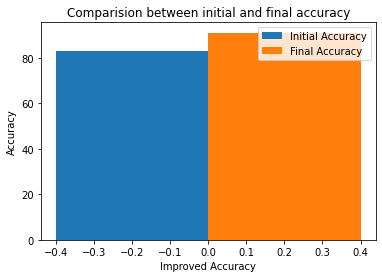

In [20]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Improved Accuracy']
Y = [initial_acc]
Z = [improved_acc]
  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, Y, 0.4, label = 'Initial Accuracy')
plt.bar(X_axis + 0.2, Z, 0.4, label = 'Final Accuracy')
  
plt.xlabel("Improved Accuracy")
plt.ylabel("Accuracy")
plt.title("Comparision between initial and final accuracy")
plt.legend()
plt.show()

import turtle
def drawBar(t, height, color):
    t.fillcolor(color)
    t.begin_fill()
    t.left(90)
    t.forward(height)
    t.write(str(height))
    t.right(90)
    t.forward(40)
    t.right(90)
    t.forward(height)
    t.left(90)
    t.end_fill()

xs = [initial_acc, improved_acc]
clrs = ["green", "red"]

maxheight = max(xs)
numbers = len(xs)
border = 10
wn = turtle.Screen()
wn.setworldcoordinates(0 - border, 0 - border, 40 * numbers + border, maxheight + border)

tess = turtle.Turtle()
tess.pensize(3)

for i in range(len(xs)):
    drawBar (tess, xs[i], clrs[i])

wn.exitonclick()